# Importing Libraries & datasets

In [597]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [598]:
df1 = pd.read_excel("dataset\ProductA.xlsx")
df2 = pd.read_excel("dataset\ProductA_google_clicks.xlsx")
df3 = pd.read_excel("dataset\ProductA_fb_impressions.xlsx")

# Data Preprocessing

### Merging datasets

In [599]:
df4 = pd.merge(df1, df2, on="Day Index", how="left")        # left joined
df = pd.merge(df4, df3, on="Day Index", how="left")

In [600]:
df.head()

,Day Index,Quantity,Clicks,Impressions
0,2021-12-01,14,445,620
1,2021-12-02,10,433,890
2,2021-12-03,13,424,851
3,2021-12-04,22,427,881
4,2021-12-05,33,451,678


### Descriptive Statistics

In [601]:
df.shape

(212, 4)

| Rows | Columns |
|------|---------|
| 212  | 4       |


In [602]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Day Index    212 non-null    datetime64[ns]
 1   Quantity     212 non-null    int64         
 2   Clicks       212 non-null    int64         
 3   Impressions  212 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 6.8 KB


In [603]:
df.describe()

,Day Index,Quantity,Clicks,Impressions
count,212,212.000000,212.00000,212.000000
mean,2022-03-16 12:00:00,17.542453,358.20283,1531.702830
min,2021-12-01 00:00:00,5.000000,60.00000,620.000000
25%,2022-01-22 18:00:00,13.750000,154.00000,1209.750000
50%,2022-03-16 12:00:00,17.000000,402.50000,1460.000000
75%,2022-05-08 06:00:00,21.000000,492.75000,1862.000000
max,2022-06-30 00:00:00,38.000000,726.00000,2707.000000
std,NaN,5.790423,164.52160,440.660783


### Missing values - Imputation

In [604]:
print("NULL Values:")
df.isnull().sum()

NULL Values:


Day Index      0
Quantity       0
Clicks         0
Impressions    0
dtype: int64

Hence, there are no NULL values. So, No imputation needed.

### Dropping Duplicates

In [605]:
df.shape

(212, 4)

In [606]:
df.drop_duplicates()

,Day Index,Quantity,Clicks,Impressions
0,2021-12-01,14,445,620
1,2021-12-02,10,433,890
2,2021-12-03,13,424,851
3,2021-12-04,22,427,881
4,2021-12-05,33,451,678
...,...,...,...,...
207,2022-06-26,13,114,1218
208,2022-06-27,16,106,1311
209,2022-06-28,13,109,885
210,2022-06-29,16,60,1000


No row dropped after drop_duplicates() ! Hence, No duplicates found! 


### Analysing Outliers

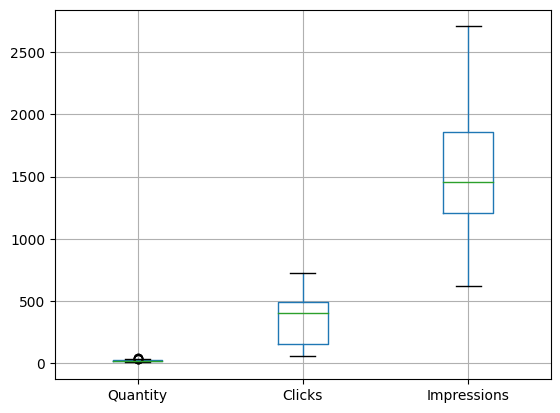

In [607]:
plt.figure()
df.boxplot()
plt.show()

In [608]:
def find_outliers_IQR(df):
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    IQR=q3-q1
    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
    return outliers

print("Outliers in each dependent attribute:")
print(f"Quantity:\t {len(find_outliers_IQR(df['Quantity']))}")
print(f"Clicks:\t\t {len(find_outliers_IQR(df['Clicks']))}")
print(f"Impressions:\t {len(find_outliers_IQR(df['Impressions']))}")

Outliers in each dependent attribute:
Quantity:	 5
Clicks:		 0
Impressions:	 0


So, there are 5 outliers in the *Quantity* attribute

In [609]:
print(f"Quantity:\n{find_outliers_IQR(df['Quantity'])}")

Quantity:
4      33
9      38
78     38
113    32
142    36
Name: Quantity, dtype: int64


***

### Replacing Outliers with 97th percentile value

In [610]:
percentile_95_value = df["Quantity"].quantile(0.97)
print(percentile_95_value)

30.669999999999987


In [611]:
def impute_outliers_97th_percentile(series):
    q1, q3 = series.quantile([0.25, 0.75])
    IQR = q3 - q1
    lower_bound, upper_bound = q1 - 1.5 * IQR, q3 + 1.5 * IQR
    percentile_95_value = series.quantile(0.97)
    return series.apply(lambda x: percentile_95_value if x < lower_bound or x > upper_bound else x)

In [612]:
df['imputed_Quantity'] = impute_outliers_97th_percentile(df['Quantity'])

In [613]:
print("Outliers in each dependent attribute:")
print(f"Quantity:\t {len(find_outliers_IQR(df['imputed_Quantity']))}")

Outliers in each dependent attribute:
Quantity:	 0


Hence, the outliers are replaced by 97th percentile values.

# Feature Engineering

In [614]:
df.head()

,Day Index,Quantity,Clicks,Impressions,imputed_Quantity
0,2021-12-01,14,445,620,14.00
1,2021-12-02,10,433,890,10.00
2,2021-12-03,13,424,851,13.00
3,2021-12-04,22,427,881,22.00
4,2021-12-05,33,451,678,30.67


Imputed_Quantity signifies the quantity column where outliers are set on 97th percentile.

In [615]:
df['imputed_Quantity'] = impute_outliers_97th_percentile(df['Quantity'])

Log Tranformed attributes

In [616]:
df['log_Quantity'] = np.log1p(df['Quantity'])
df['log_Clicks'] = np.log1p(df['Clicks'])
df['log_Impressions'] = np.log1p(df['Impressions'])

Extract Month and Year

In [617]:
df['YearMonth'] = df['Day Index'].dt.to_period('M')

Extract Month Name

In [618]:
df['MonthName'] = df['YearMonth'].dt.strftime('%B')
month_order = ['December', 'January', 'February', 'March', 'April', 'May', 'June']  
df['MonthName'] = pd.Categorical(df['MonthName'], categories=month_order, ordered=True)

Extract day of the Week

In [619]:
df['DayOfWeek'] = df['Day Index'].dt.day_name()
week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']  
df['DayOfWeek'] = pd.Categorical(df['DayOfWeek'], categories=week_order, ordered=True)

Reindexing the attributes for better understanding and clear view of the data


In [620]:
order = ["Day Index", "YearMonth", "MonthName", "DayOfWeek", "Quantity", "Clicks", "Impressions", "imputed_Quantity", "log_Quantity", "log_Clicks", "log_Impressions"]
df = df[order]

final data

In [621]:
df.head()

,Day Index,YearMonth,MonthName,DayOfWeek,Quantity,Clicks,Impressions,imputed_Quantity,log_Quantity,log_Clicks,log_Impressions
0,2021-12-01,2021-12,December,Wednesday,14,445,620,14.00,2.708050,6.100319,6.431331
1,2021-12-02,2021-12,December,Thursday,10,433,890,10.00,2.397895,6.073045,6.792344
2,2021-12-03,2021-12,December,Friday,13,424,851,13.00,2.639057,6.052089,6.747587
3,2021-12-04,2021-12,December,Saturday,22,427,881,22.00,3.135494,6.059123,6.782192
4,2021-12-05,2021-12,December,Sunday,33,451,678,30.67,3.526361,6.113682,6.520621


exporting the final dataset for further analysis

In [622]:
# df.to_excel('final_df.xlsx', index=False)   


# Data Analysis

### Correlation Heatmap

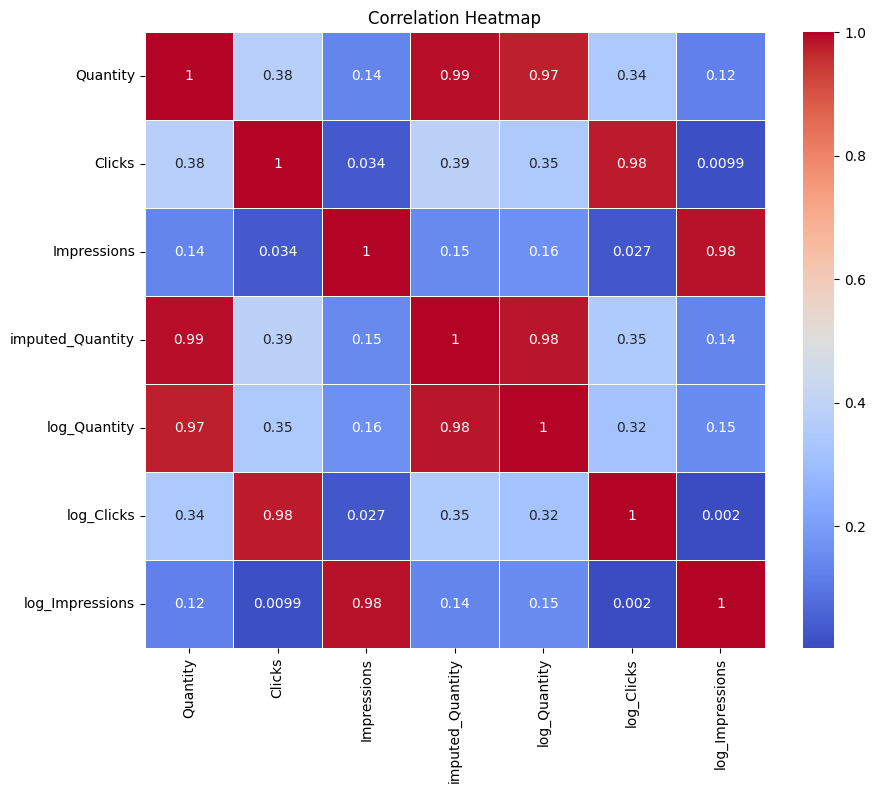

In [623]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True,  cmap='coolwarm', linewidths=0.5).set_title("Correlation Heatmap")
plt.show()

Through the above correlation heatmap, we can say that :
* Clicks have good correlation with Quantity
* Impressions also have slight relation to Quantity
* Impression have very tiny relation to clicks


### 1. How Clicks affect the Product's quantity?

<i>Function for plotting Linear Regression

In [624]:
# Define function for plotting regression
def plot_regression(df, x_col, y_col, title, ax):
    x = df[x_col].values.reshape(-1, 1)
    y = df[y_col].values
    
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)
    slope = model.coef_[0]
    
    ax.scatter(df[x_col], df[y_col], label='Actual Data')
    ax.plot(df[x_col], y_pred, color='red', label='Regression Line')
    ax.set_title(title)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.legend()
    return slope

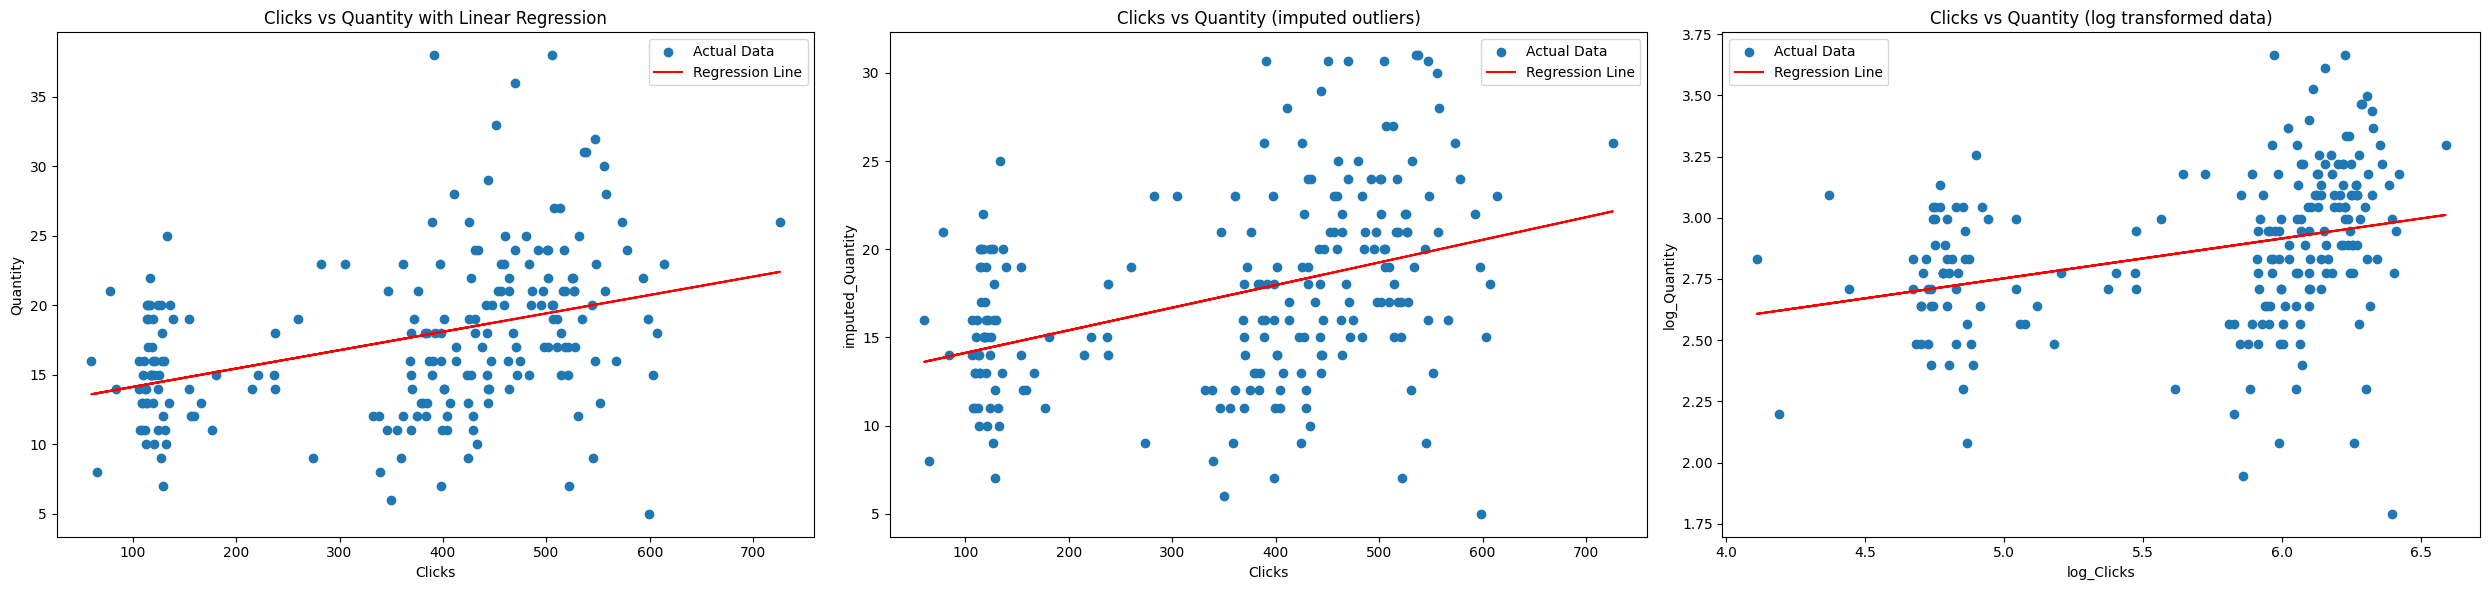

The slope of the linear regression model for original data is: 0.013234961483654805
The slope of the linear regression model for data with imputed outliers is: 0.012818303346978916
The slope of the linear regression model for log transformed data is: 0.16298656613150664


In [625]:
# Create subplots for plotting
fig, axes = plt.subplots(1, 3, figsize=(25, 6))

# Plotting regression for different scenarios
slope_original = plot_regression(df, 'Clicks', 'Quantity', 'Clicks vs Quantity with Linear Regression', axes[0])
imputed_slope = plot_regression(df, 'Clicks', 'imputed_Quantity', 'Clicks vs Quantity (imputed outliers)', axes[1])
slope_log = plot_regression(df, 'log_Clicks', 'log_Quantity', 'Clicks vs Quantity (log transformed data)', axes[2])

plt.tight_layout()
plt.show()

# Print slopes
print(f"The slope of the linear regression model for original data is: {slope_original}")
print(f"The slope of the linear regression model for data with imputed outliers is: {imputed_slope}")
print(f"The slope of the linear regression model for log transformed data is: {slope_log}")

Hence, there is a relation with +ve slope, i.e. Quantity increases as Clicks increases.
***

### 2. How Impressions affect the Product's quantity?

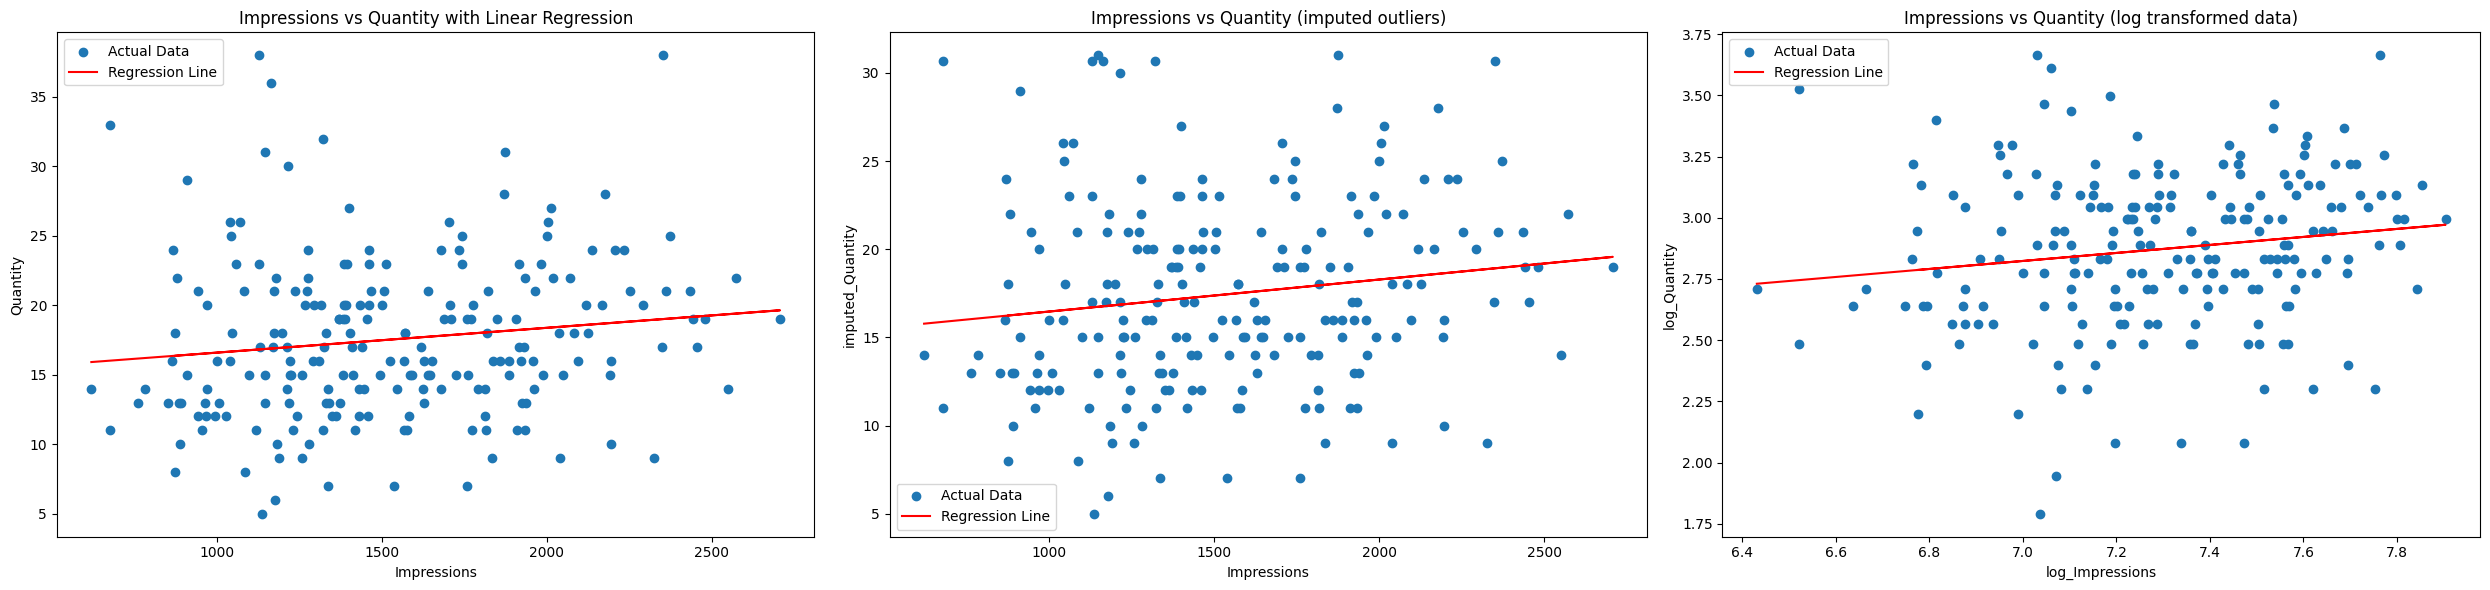

The slope of the linear regression model for original data is: 0.0017863293104571235
The slope of the linear regression model for data with imputed outliers is: 0.0018151514524222265
The slope of the linear regression model for log transformed data is: 0.16352913564679306


In [626]:
# Create subplots for plotting
fig, axes = plt.subplots(1, 3, figsize=(25, 6))

# Plotting regression for different scenarios
slope_original = plot_regression(df, 'Impressions', 'Quantity', 'Impressions vs Quantity with Linear Regression', axes[0])
imputed_slope = plot_regression(df, 'Impressions', 'imputed_Quantity', 'Impressions vs Quantity (imputed outliers)', axes[1])
slope_log = plot_regression(df, 'log_Impressions', 'log_Quantity', 'Impressions vs Quantity (log transformed data)', axes[2])

plt.tight_layout()
plt.show()

# Print slopes
print(f"The slope of the linear regression model for original data is: {slope_original}")
print(f"The slope of the linear regression model for data with imputed outliers is: {imputed_slope}")
print(f"The slope of the linear regression model for log transformed data is: {slope_log}")

Hence, there is a +ve slope that means an increase in impressions can slightly increase the quantity demanded.
***

### 3. Does more impressions lead to more clicks?

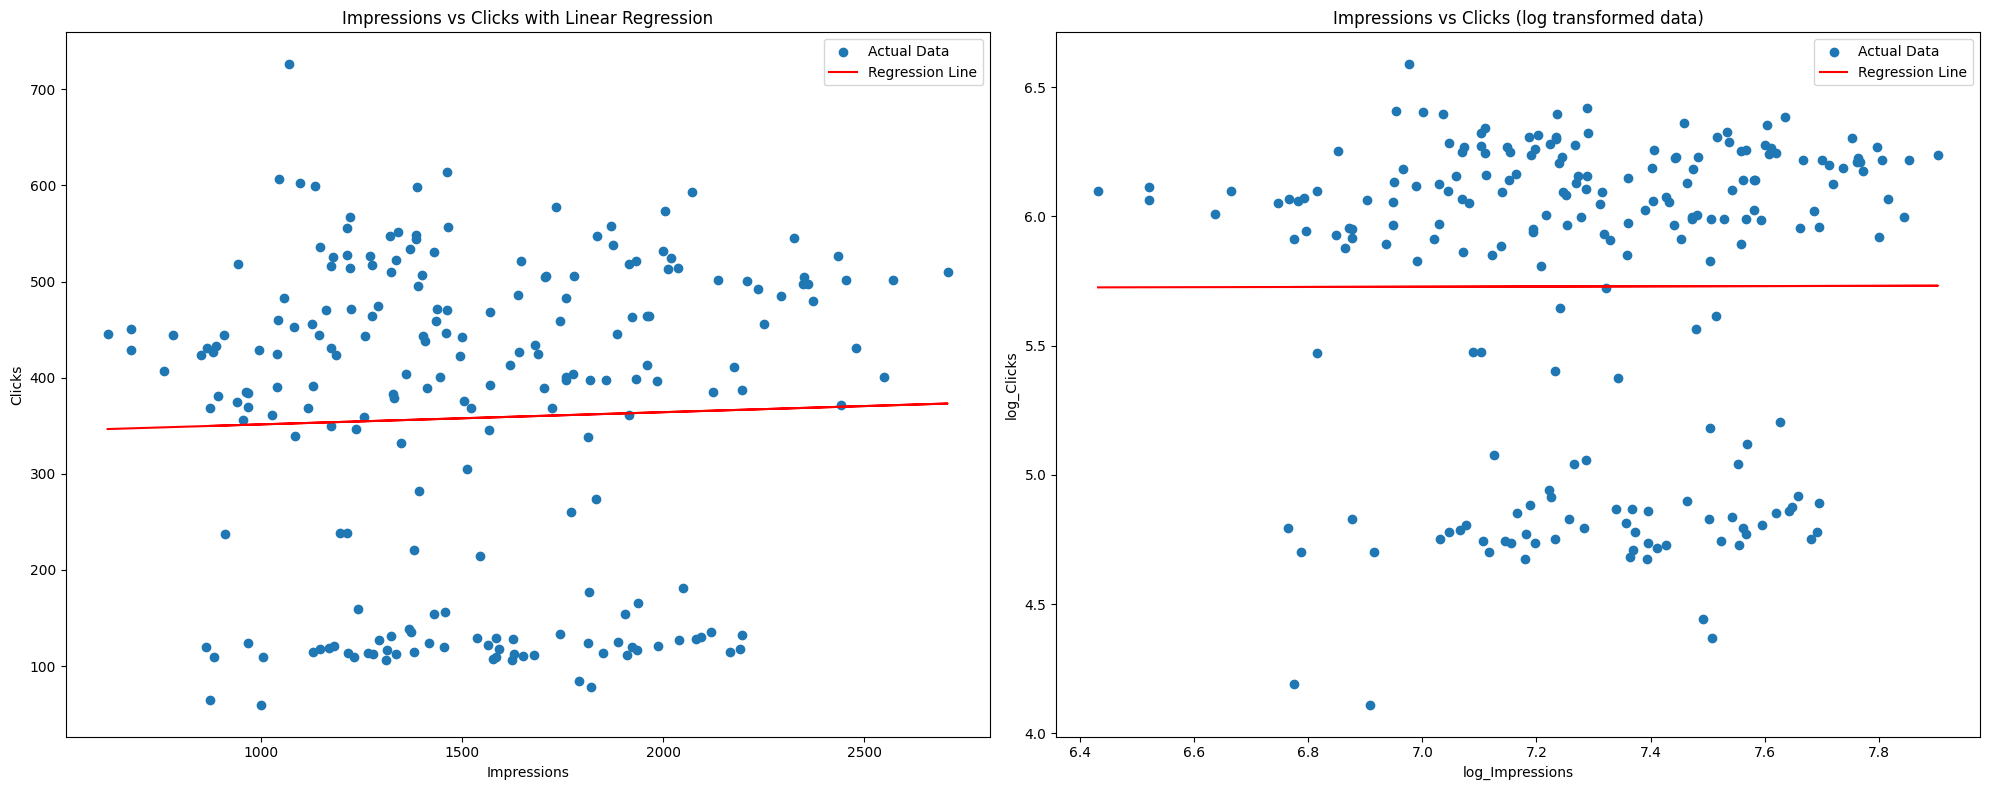

The slope of the linear regression model for original data is: 0.012709310479620622
The slope of the linear regression model for log transformed data is: 0.004241626376529049


In [627]:
# Create subplots for plotting
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plotting regression for different scenarios
slope_original = plot_regression(df, 'Impressions', 'Clicks', 'Impressions vs Clicks with Linear Regression', axes[0])
slope_log = plot_regression(df, 'log_Impressions', 'log_Clicks', 'Impressions vs Clicks (log transformed data)', axes[1])

plt.tight_layout()
plt.show()

# Print slopes
print(f"The slope of the linear regression model for original data is: {slope_original}")
print(f"The slope of the linear regression model for log transformed data is: {slope_log}")

Hence the slope is +ve and thus proves the hypothesis that More impressions leads to more clicks.
***

### 4. Day wise plot for all 7 month data

#### 4.1 For Quantity

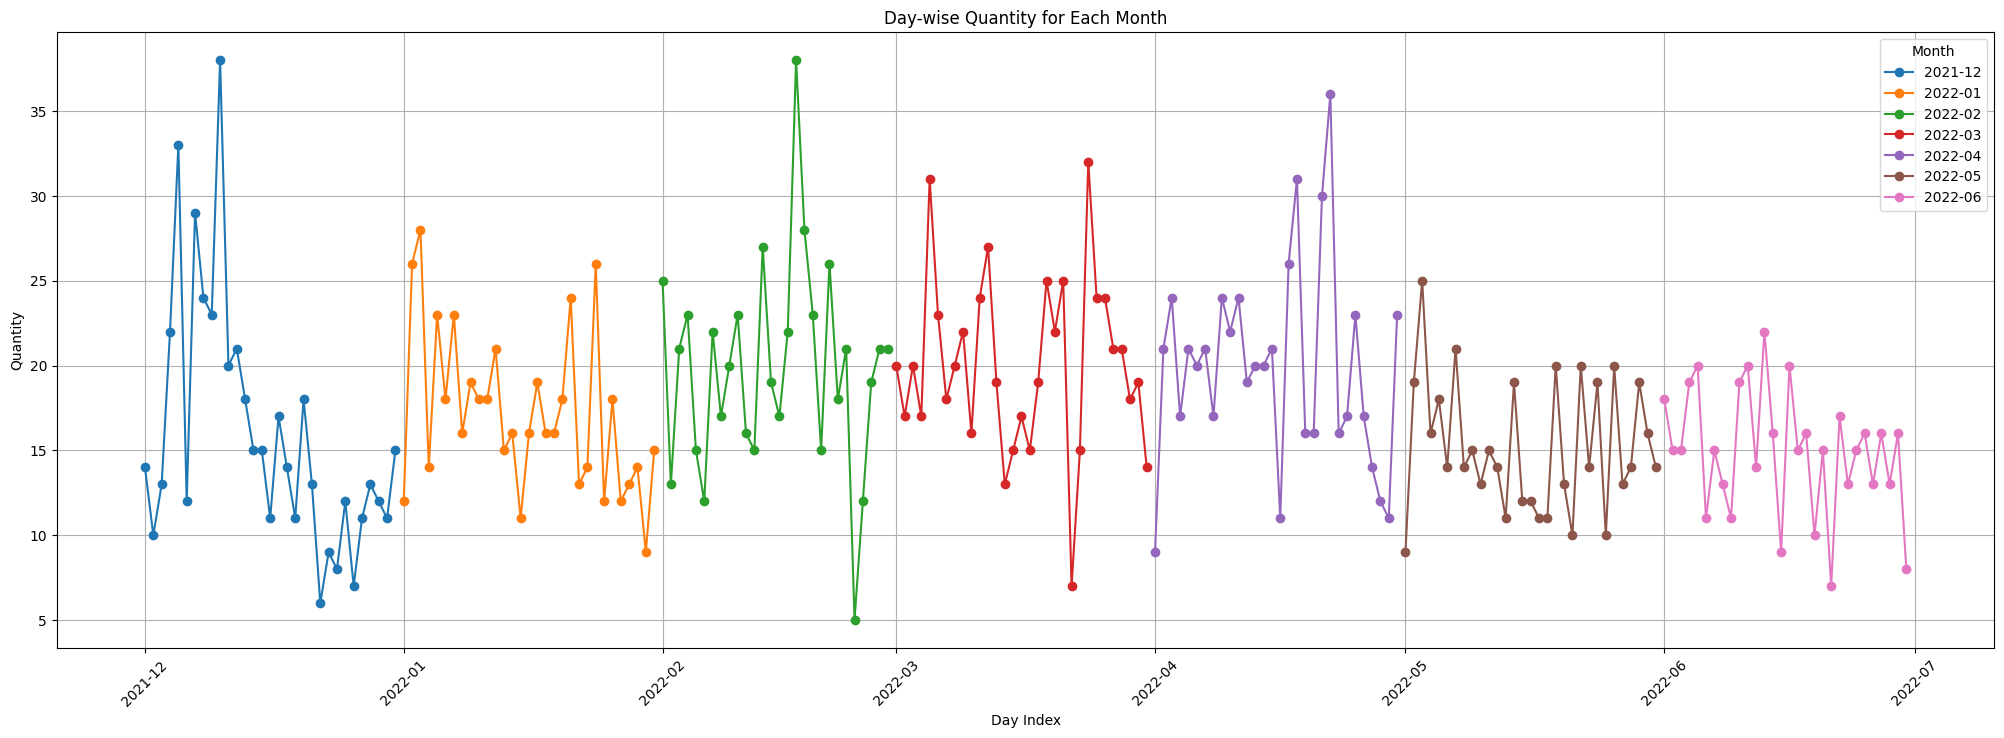

In [628]:
# Create a figure
plt.figure(figsize=(25, 8))

# Iterate over each month and plot the data
for month in df['YearMonth'].unique():
    monthly_data = df[df['YearMonth'] == month]
    plt.plot(monthly_data['Day Index'], monthly_data['Quantity'], marker='o', linestyle='-', label=str(month))

# Add title and labels
plt.title('Day-wise Quantity for Each Month')
plt.xlabel('Day Index')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.legend(title='Month', loc='best')
plt.grid(True)

# Show the plot
plt.show()


There are more peaks in the month of december, march, april and may.

#### 4.2 For Clicks

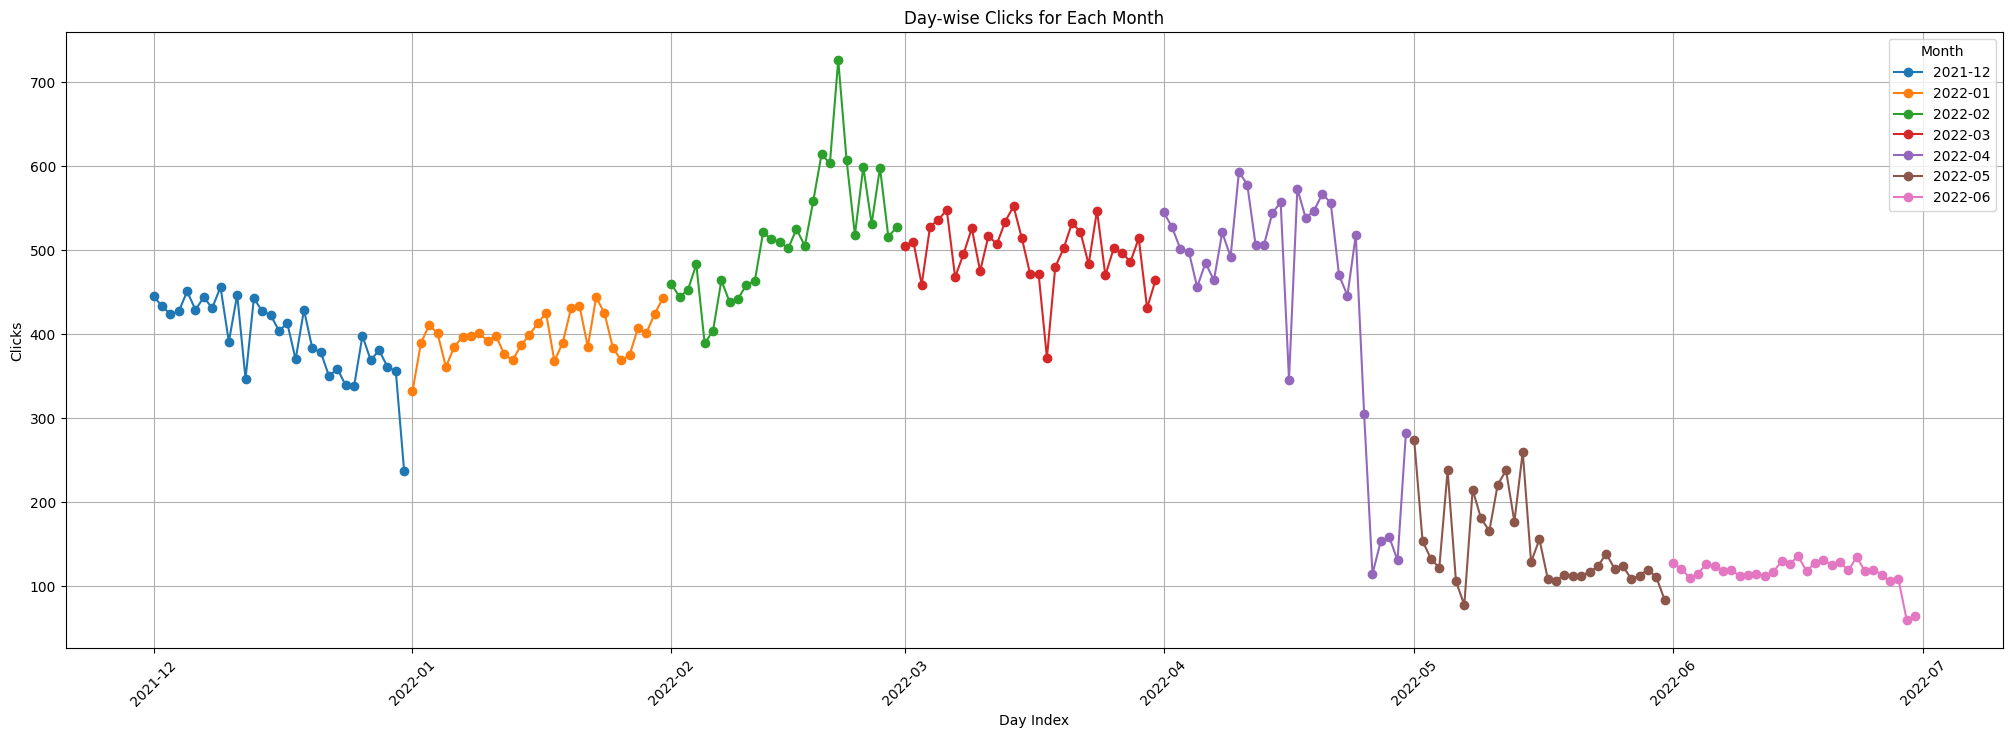

In [629]:
# Create a figure
plt.figure(figsize=(25, 8))

# Iterate over each month and plot the data
for month in df['YearMonth'].unique():
    monthly_data = df[df['YearMonth'] == month]
    plt.plot(monthly_data['Day Index'], monthly_data['Clicks'], marker='o', linestyle='-', label=str(month))

# Add title and labels
plt.title('Day-wise Clicks for Each Month')
plt.xlabel('Day Index')
plt.ylabel('Clicks')
plt.xticks(rotation=45)
plt.legend(title='Month', loc='best')
plt.grid(True)

# Show the plot
plt.show()


Month of May and June have loswest Clicks, while februaury has highest peak

#### 4.3 For Impressions

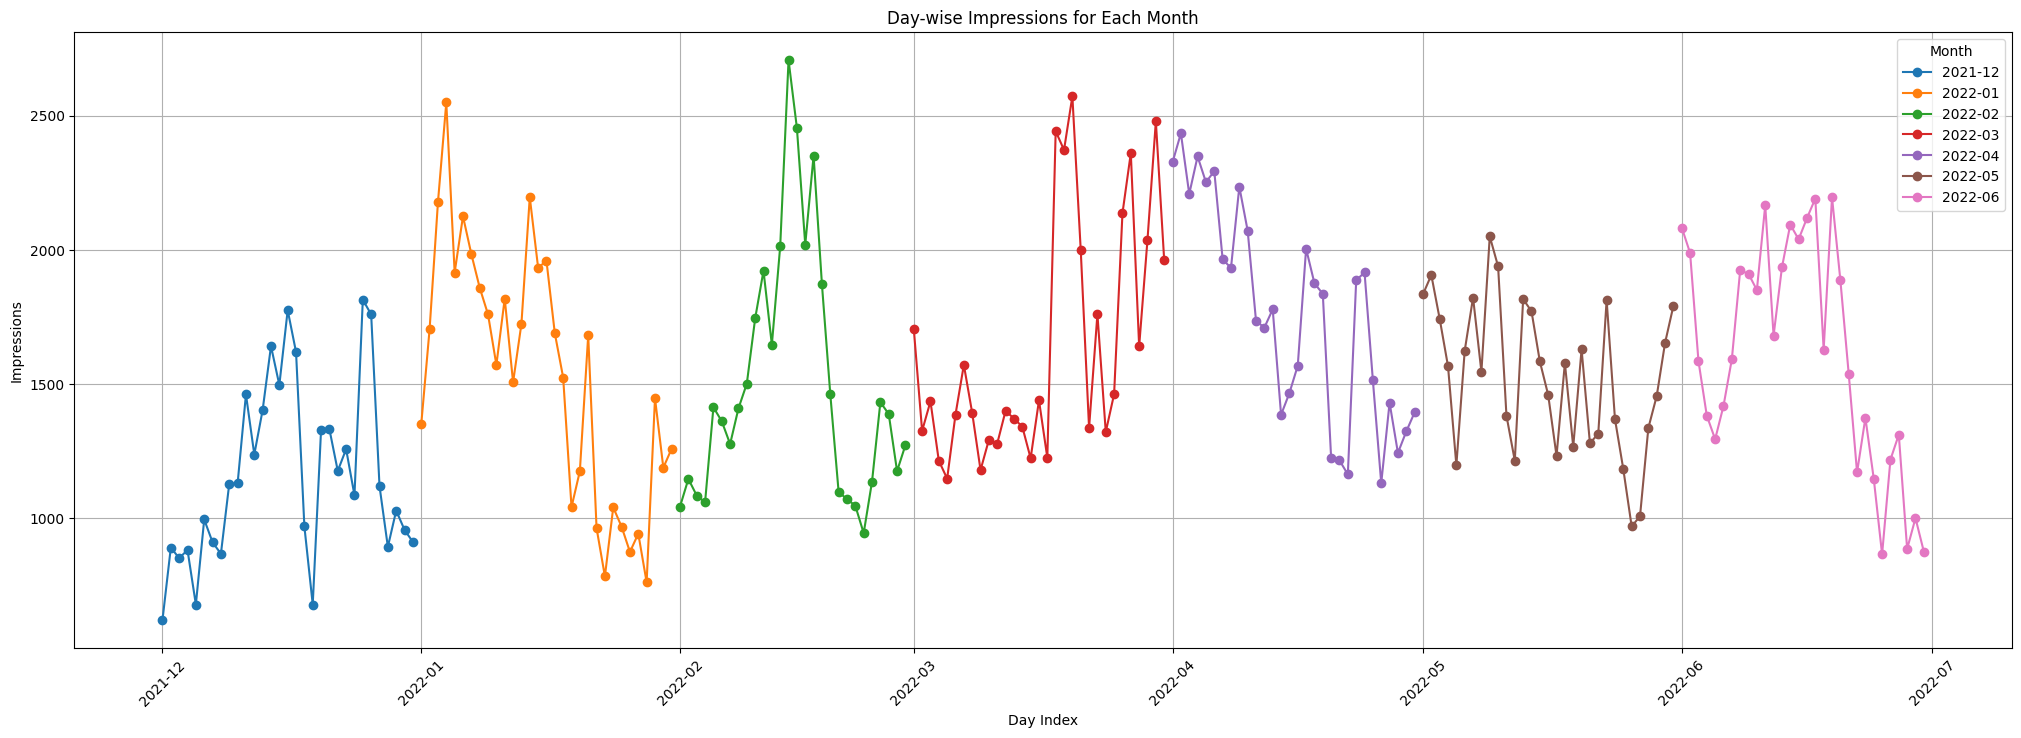

In [630]:
# Create a figure
plt.figure(figsize=(25, 8))

# Iterate over each month and plot the data
for month in df['YearMonth'].unique():
    monthly_data = df[df['YearMonth'] == month]
    plt.plot(monthly_data['Day Index'], monthly_data['Impressions'], marker='o', linestyle='-', label=str(month))

# Add title and labels
plt.title('Day-wise Impressions for Each Month')
plt.xlabel('Day Index')
plt.ylabel('Impressions')
plt.xticks(rotation=45)
plt.legend(title='Month', loc='best')
plt.grid(True)

# Show the plot
plt.show()


Highest peak of impressions is in the month of March, followed by February and april.

### 5. Monthly plot

#### 5.1 For quantity

In [631]:
def annotate_points(ax, x, y, values):
    for i, txt in enumerate(values):
        ax.annotate(f'{txt:.0f}', (x[i], y[i]), textcoords="offset points", xytext=(0,5), ha='center')

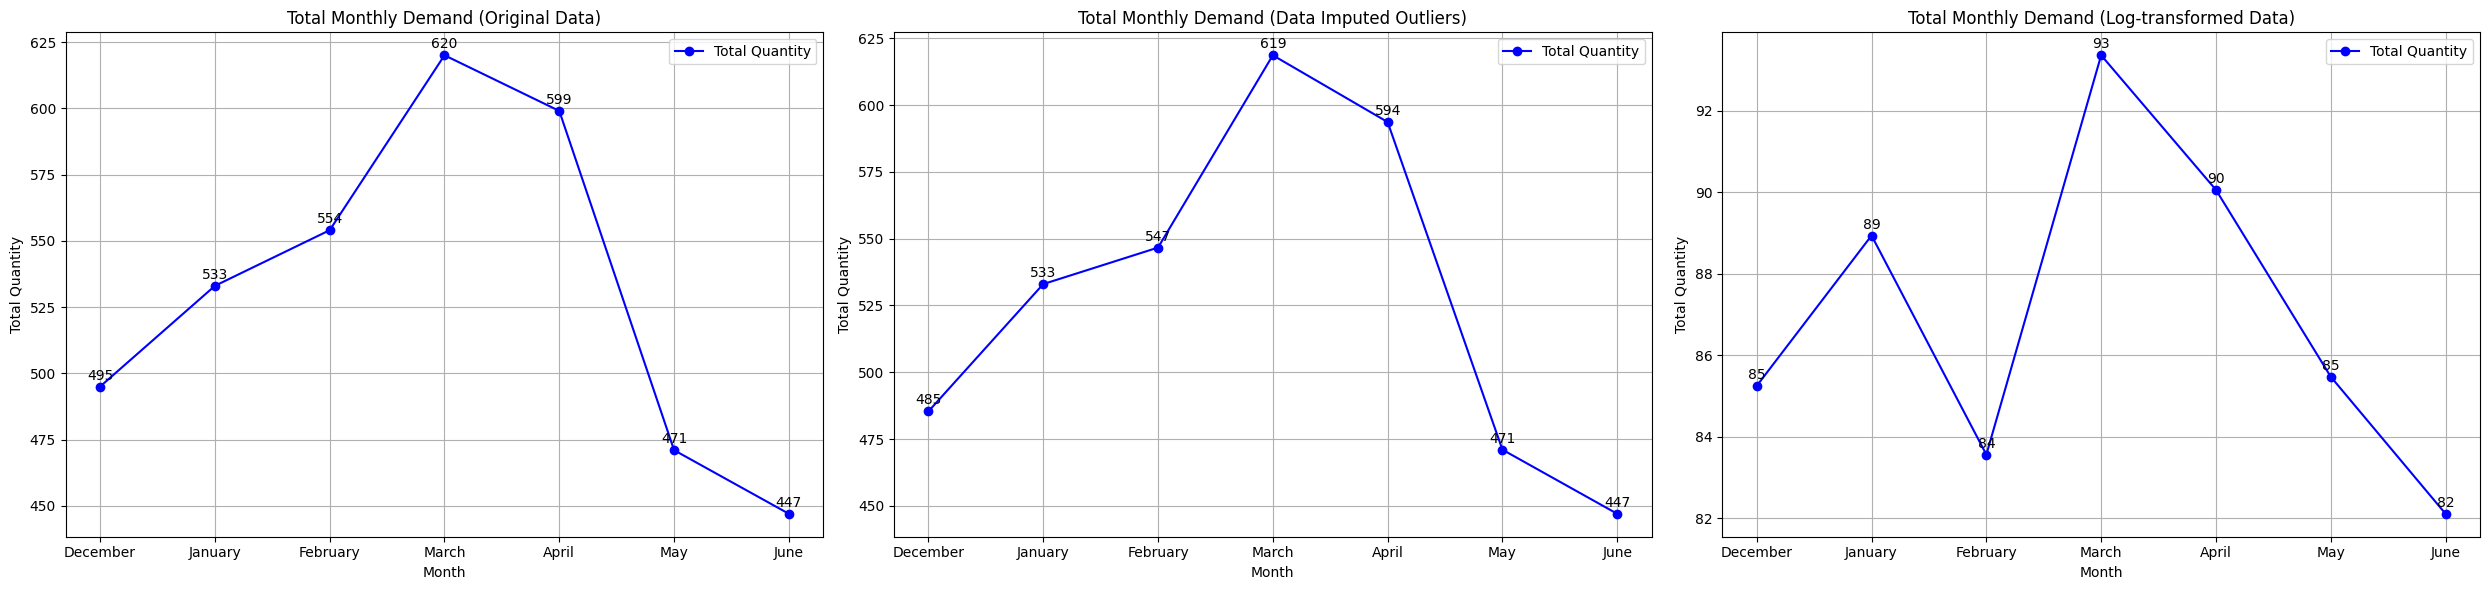

In [632]:
def plot_monthly_demand(df, x_col, y_col, title, ax):
    df1 = df.groupby(x_col)[y_col].sum().reset_index()
    df1 = df1.sort_values(by=x_col)
    ax.plot(df1[x_col], df1[y_col], marker='o', color='blue', label='Total Quantity')
    annotate_points(ax, df1[x_col], df1[y_col], df1[y_col])
    del df1
    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel('Total Quantity')
    ax.grid(True)
    ax.legend()

# Plotting side by side
fig, axes = plt.subplots(1, 3, figsize=(25, 6))

plot_monthly_demand(df, 'MonthName', 'Quantity', 'Total Monthly Demand (Original Data)', axes[0])
plot_monthly_demand(df, 'MonthName', 'imputed_Quantity', 'Total Monthly Demand (Data Imputed Outliers)', axes[1])
plot_monthly_demand(df, 'MonthName', 'log_Quantity', 'Total Monthly Demand (Log-transformed Data)', axes[2])

plt.tight_layout()
plt.show()

* Hence, the total quantity demanded of Product A increases as winters arrive and reaches its peak in March and then declines rapidly.
* Peak 1 --> March (03-2022)
* Peak 2 --> April (04-2022)
***

#### 5.2 For quantity, clicks and impressions aggregated plot

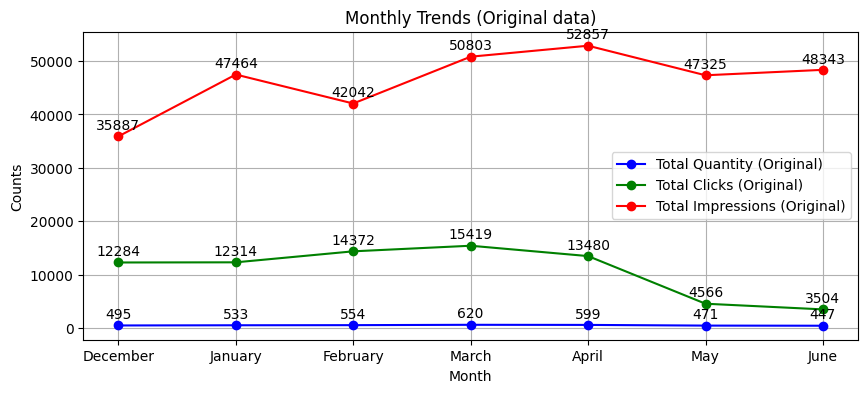

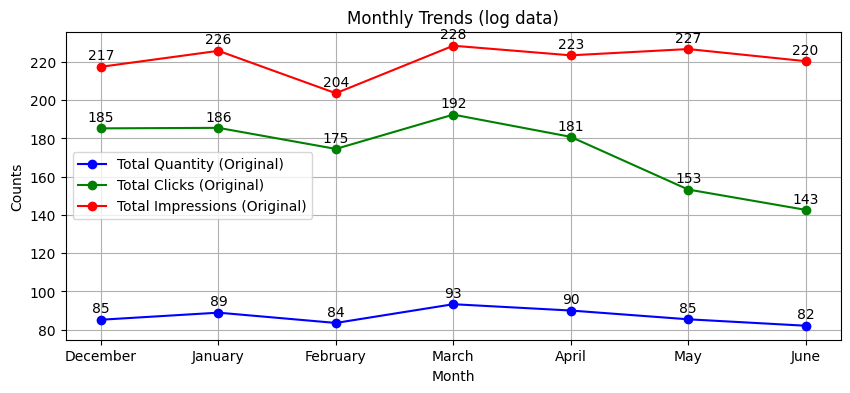

In [633]:
def plot_aggregated_monthly(df, x_col, y_cols, colors, labels, title):
    plt.figure(figsize=(10, 4))
    ax = plt.gca()
    for y_col, color, label in zip(y_cols, colors, labels):
        df1 = df.groupby(x_col)[y_col].sum().reset_index()
        df1 = df1.sort_values(by=x_col)
        plt.plot(df1[x_col], df1[y_col], marker='o', color=color, label=label)
        annotate_points(ax, df1[x_col], df1[y_col], df1[y_col])
        del df1

    plt.title(title)
    plt.xlabel('Month')
    plt.ylabel('Counts')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_aggregated_monthly(df, 'MonthName', ['Quantity', 'Clicks', 'Impressions'], ['blue', 'green', 'red'], ['Total Quantity (Original)', 'Total Clicks (Original)', 'Total Impressions (Original)'], 'Monthly Trends (Original data)')
plot_aggregated_monthly(df, 'MonthName', ['log_Quantity', 'log_Clicks', 'log_Impressions'], ['blue', 'green', 'red'], ['Total Quantity (Original)', 'Total Clicks (Original)', 'Total Impressions (Original)'], 'Monthly Trends (log data)')

* As we can see in the above log transformed one, we can see that in the month of march (03-2022), all 3 attributes hit their peaks.
* Meanwhile in all 3 plots, impressions and quantity peaks in march .

### 6. Day of the Week wise plot

#### 6.1 For Quantity

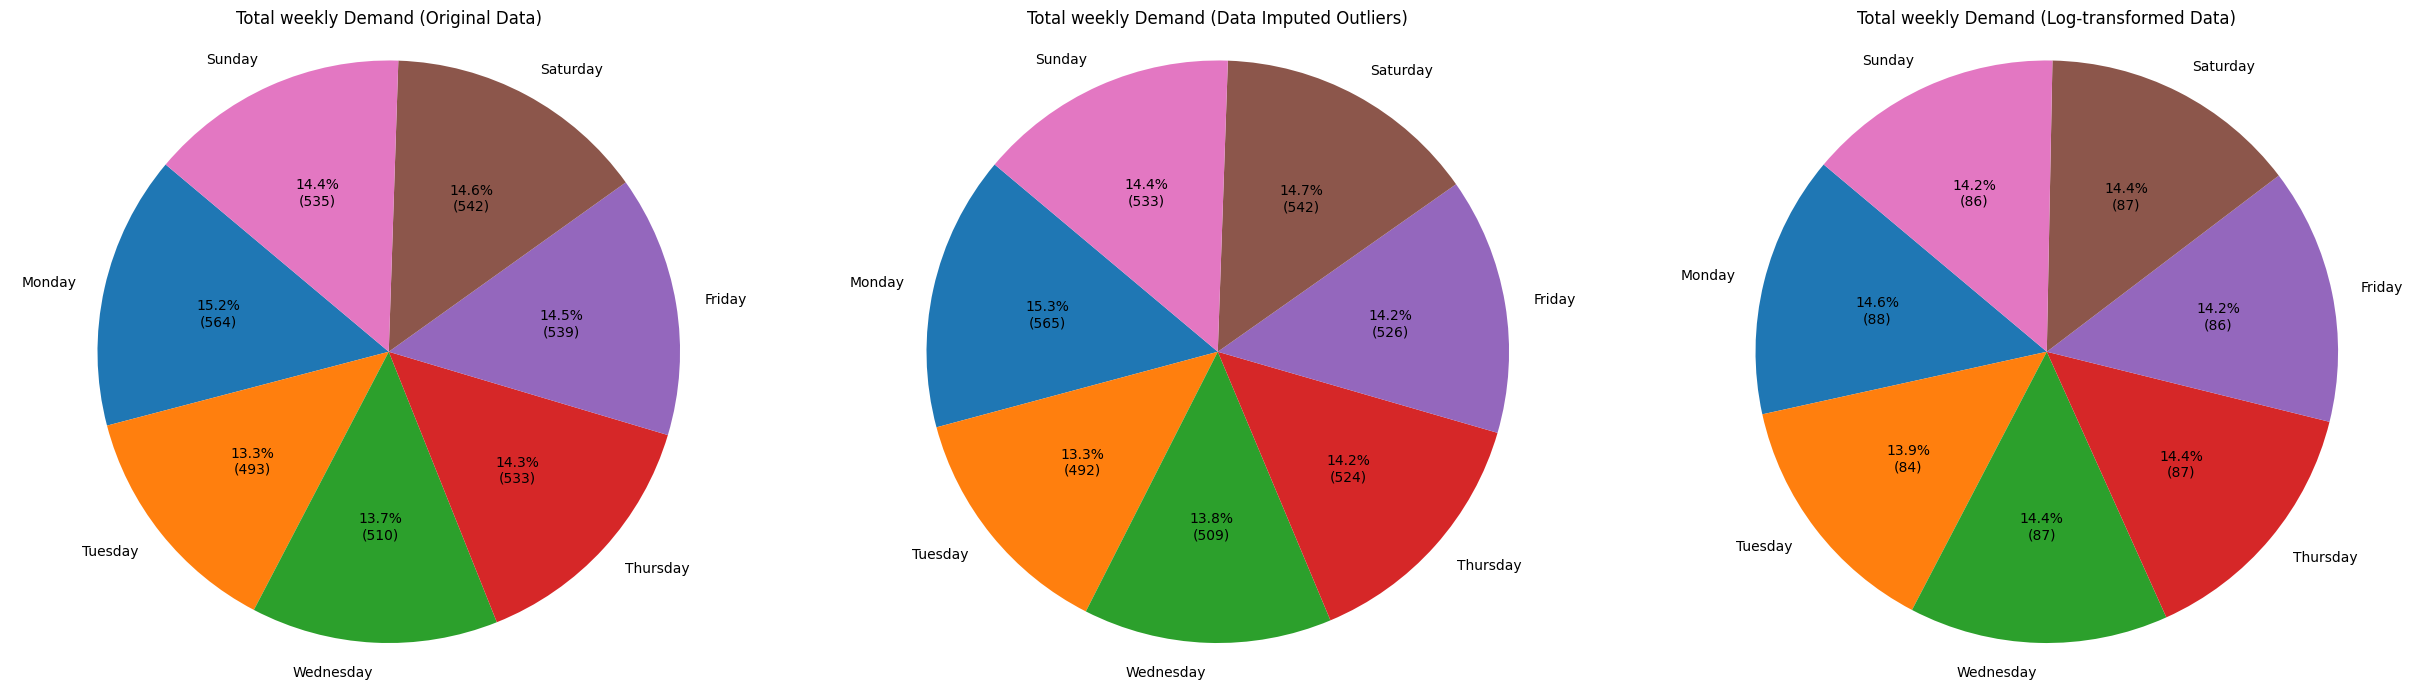

In [634]:
def plot_weekly_demand(df, x_col, y_col, title, ax):
    df1 = df.groupby(x_col)[y_col].sum().reset_index()
    df1 = df1.sort_values(by=x_col)
    labels = df1[x_col]
    sizes = df1[y_col]
    ax.pie(sizes, labels=labels, autopct=lambda pct: f'{pct:.1f}%\n({int(pct * sum(sizes) / 100)})', startangle=140)
    ax.set_title(title)
    ax.axis('equal')
    del df1

# Plotting side by side
fig, axes = plt.subplots(1, 3, figsize=(25, 7))
plot_weekly_demand(df, 'DayOfWeek', 'Quantity', 'Total weekly Demand (Original Data)', axes[0])
plot_weekly_demand(df, 'DayOfWeek', 'imputed_Quantity', 'Total weekly Demand (Data Imputed Outliers)', axes[1])
plot_weekly_demand(df, 'DayOfWeek', 'log_Quantity', 'Total weekly Demand (Log-transformed Data)', axes[2])
plt.tight_layout()
plt.show()

As we can derive 2 conclusions from the total Product's quantity of each day:
* Monday accounts for the highest Product's quantity demand.
* Tuesdays accounts for the lowest Product's quantity demand.

***

#### 6.2 For Quantity, Clicks and Impressions Aggregated

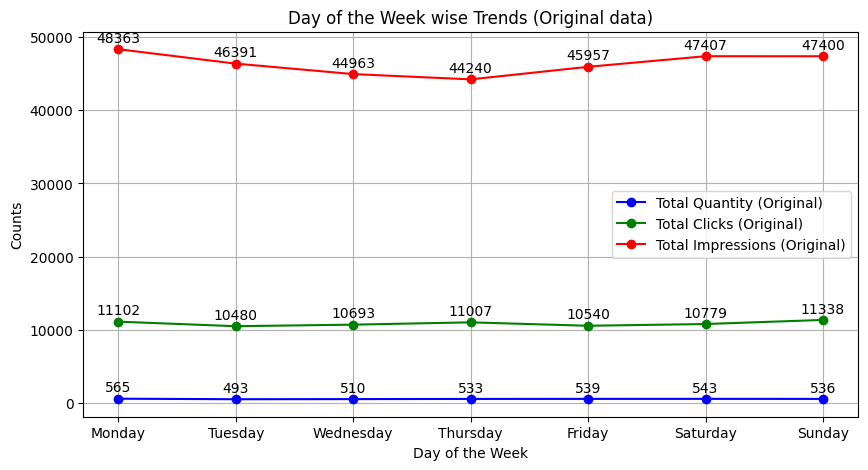

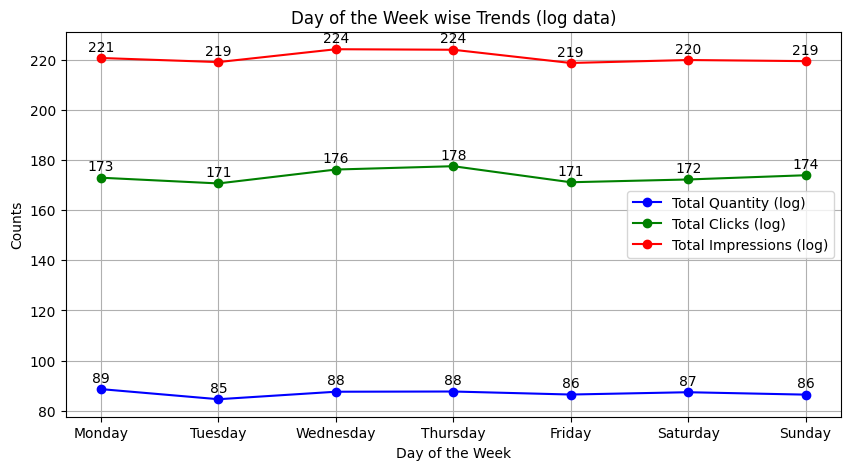

In [635]:
def plot_aggregated_weekly(df, x_col, y_cols, colors, labels, title):
    plt.figure(figsize=(10, 5))
    ax = plt.gca()

    for y_col, color, label in zip(y_cols, colors, labels):
        df1 = df.groupby(x_col)[y_col].sum().reset_index()
        df1 = df1.sort_values(by=x_col)
        plt.plot(df1[x_col], df1[y_col], marker='o', color=color, label=label)
        annotate_points(ax, df1[x_col], df1[y_col], df1[y_col])
        del df1
    plt.title(title)
    plt.xlabel('Day of the Week')
    plt.ylabel('Counts')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_aggregated_weekly(df, 'DayOfWeek', ['Quantity', 'Clicks', 'Impressions'], ['blue', 'green', 'red'], ['Total Quantity (Original)', 'Total Clicks (Original)', 'Total Impressions (Original)'], 'Day of the Week wise Trends (Original data)')
plot_aggregated_weekly(df, 'DayOfWeek', ['log_Quantity', 'log_Clicks', 'log_Impressions'], ['blue', 'green', 'red'], ['Total Quantity (log)', 'Total Clicks (log)', 'Total Impressions (log)'], 'Day of the Week wise Trends (log data)')

From the plot, we can derive following conclusions:
* <i>in original data plot</i>
    * Weekends (saturday, sundays) and monday have high impressions and clicks
    * Also, Thursday accounts for highest clicks
* <i>in log-transformed data plot</i> 
    * Wednesday and Thursday accounts for high impressions and clicks 

***
# Time Series Analysis


## Hyperparameter Tuning 

### Checking Stationarity of the Data

In [636]:
def adfuller_test(series, series_name, signif=0.05):
    result = adfuller(series, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[1] <= signif:
        print(f" => {series_name} is Stationary. (Reject the null hypothesis)")
    else:
        print(f" => {series_name} is Non-Stationary. (Fail to reject the null hypothesis)")

# Perform Dickey-Fuller test on the data
for i in list(["Quantity", "Clicks", "Impressions"]):
    print(f"ADF Test for {i}:")
    adfuller_test(df[i], i)
    print("-"*70)

ADF Test for Quantity:
ADF Statistic: -4.445717448758575
p-value: 0.00024615679644112006
Critical Values:
	1%: -3.4621857592784546
	5%: -2.875537986778846
	10%: -2.574231080806213
 => Quantity is Stationary. (Reject the null hypothesis)
----------------------------------------------------------------------
ADF Test for Clicks:
ADF Statistic: -0.8705717270828215
p-value: 0.797509057499528
Critical Values:
	1%: -3.4620315036789666
	5%: -2.8754705024827127
	10%: -2.5741950726860647
 => Clicks is Non-Stationary. (Fail to reject the null hypothesis)
----------------------------------------------------------------------
ADF Test for Impressions:
ADF Statistic: -5.6962061101258685
p-value: 7.863580125889645e-07
Critical Values:
	1%: -3.46172743446274
	5%: -2.8753374677799957
	10%: -2.574124089081557
 => Impressions is Stationary. (Reject the null hypothesis)
----------------------------------------------------------------------


<b><i>Data series is stationary for Quantity and Impressions attribute.

In [637]:
# Function to make a series stationary
def make_stationary(series):
    series_log = np.sqrt(series)
    series_diff = series_log.diff().dropna()
    return series_diff

df["Clicks_stationary"] = make_stationary(df["Clicks"])

<b><i>Making Clicks_stationary

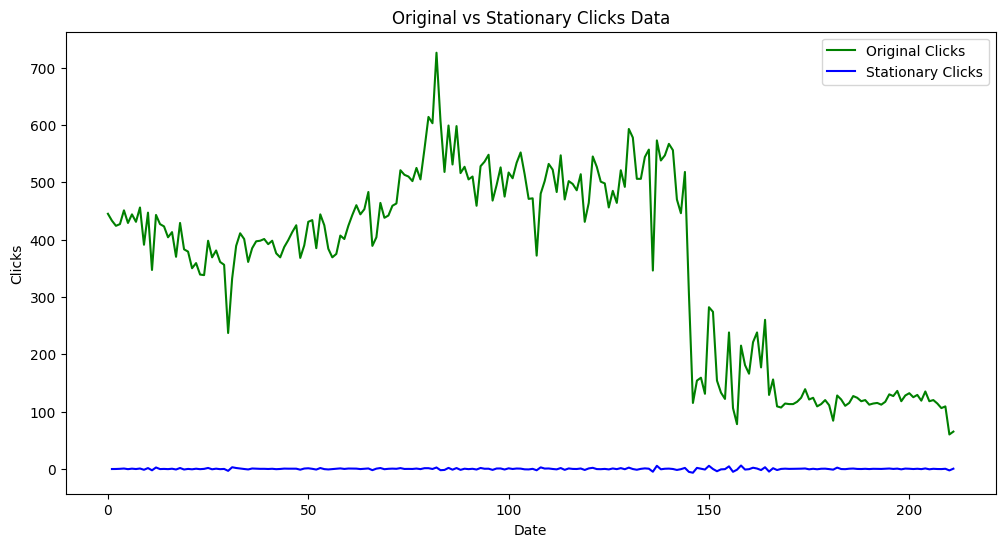

In [638]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Clicks'], label='Original Clicks', color='green')
plt.plot(df.index, df['Clicks_stationary'], label='Stationary Clicks', color='blue')
plt.title('Original vs Stationary Clicks Data')
plt.xlabel('Date')
plt.ylabel('Clicks')
plt.legend()
plt.show()

<b><i>Hence, Clicks_stationary is a stationary series.

### Plotting ACF and PACF plots

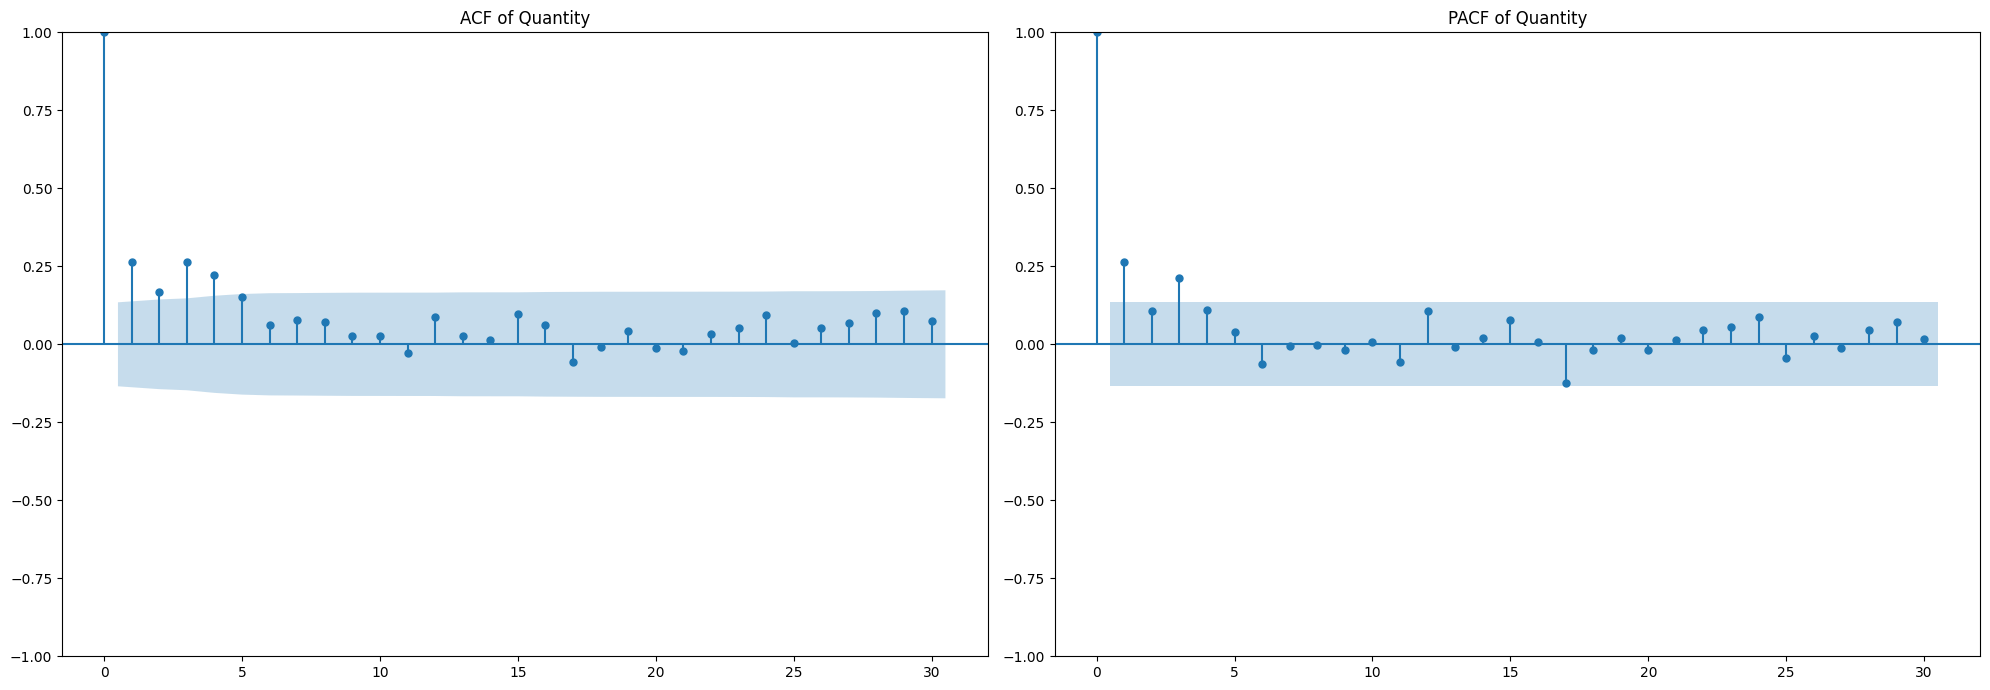

In [639]:
# Create subplots for ACF and PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# ACF plot
plot_acf(df['Quantity'], lags=30, ax=ax1)
ax1.set_title('ACF of Quantity')

# PACF plot
plot_pacf(df['Quantity'], lags=30, ax=ax2)
ax2.set_title('PACF of Quantity')

plt.tight_layout()
plt.show()


### Determining Optimal Parameters

<i><b>Value of differencing is zero, d = 0.</b> (Since, data series for quantity is stationary)<p>
<i><b>And The value of p = 1 and q = 1 for Quantity.</b> (Since each plot have a single biggest spike)<p>

## Data Splitting

<table>
  <tr>
    <th>Data set</th>
    <th>percentage</th>
    <th>Num of days</th>
  </tr>
  <tr>
    <td>train set</td>
    <td>60 %</td>
    <td>127 days</td>
  </tr>
  <tr>
    <td>validation set</td>
    <td>20 %</td>
    <td>42 days</td>
  </tr>
  <tr>
    <td>test set</td>
    <td>20 %</td>
    <td>43 days</td>
  </tr>
</table>



In [640]:
# Calculate the split indices
train_size = int(0.6 * len(df))
val_size = int(0.2 * len(df))
test_size = len(df) - train_size - val_size

# Split the df
train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:train_size + val_size]
test_df = df.iloc[train_size + val_size:]

print("Train Data Size:\t", len(train_df))
print("Validation Data Size:\t", len(val_df))
print("Test Data Size:\t\t", len(test_df))

Train Data Size:	 127
Validation Data Size:	 42
Test Data Size:		 43


## Modelling

#### <i>functions for plotting predictions of models</i>

In [641]:
warnings.filterwarnings("ignore")       # to ignore ny warnings while fitting the model

In [642]:
def plot_predictions_and_metrics(train_df, val_df, test_df, model, model_name='Model'):
    # Make predictions
    start_train = 0
    end_train = len(train_df) - 1
    predictions_train = model.predict(start=start_train, end=end_train)

    start_val = len(train_df)
    end_val = start_val + len(val_df) - 1
    predictions_val = model.predict(start=start_val, end=end_val)
    
    start_test = len(train_df) + len(val_df)
    end_test = start_test + len(test_df) - 1
    predictions_test = model.predict(start=start_test, end=end_test)

    # Plot predictions vs actuals for training, validation, and test sets
    plt.figure(figsize=(15, 7))
    plt.plot(train_df.index, train_df['Quantity'], label='Training Data')
    plt.plot(val_df.index, val_df['Quantity'], label='Validation Data')
    plt.plot(test_df.index, test_df['Quantity'], label='Test Data')
    plt.plot(train_df.index, predictions_train, label='Training Predictions', color='blue', linestyle='--')
    plt.plot(val_df.index, predictions_val, label='Validation Predictions', color='red', linestyle='--')
    plt.plot(test_df.index, predictions_test, label='Test Predictions', color='green', linestyle='--')
    plt.title(f'{model_name} - Training vs Validation vs Test')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.show()

    # Calculate evaluation metrics
    def calculate_metrics(actual, predicted):
        mse = mean_squared_error(actual, predicted)
        mae = mean_absolute_error(actual, predicted)
        mape = np.mean(np.abs((actual - predicted) / actual)) * 100
        return mse, mae, mape.round(3)

    mse_val, mae_val, mape_val = calculate_metrics(val_df['Quantity'], predictions_val)
    mse_test, mae_test, mape_test = calculate_metrics(test_df['Quantity'], predictions_test)

    # Print evaluation metrics
    print(f'Validation Set Metrics for {model_name}:')
    print(f'MSE: {mse_val} \nMAE: {mae_val} \nMAPE: {mape_val}%')
    print(f'\nTest Set Metrics for {model_name}:')
    print(f'MSE: {mse_test} \nMAE: {mae_test} \nMAPE: {mape_test}%')
    

In [643]:
def plot_predictions_and_metrics_exog(train_df, val_df, test_df, exog_val, exog_test, model, model_name):
    # Generate predictions for the validation set
    predictions_val = model.get_forecast(steps=len(val_df), exog=exog_val).predicted_mean

    # Generate predictions for the test set
    predictions_test = model.get_forecast(steps=len(test_df), exog=exog_test).predicted_mean

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(train_df.index, train_df['Quantity'], label='Train', color='blue')
    plt.plot(val_df.index, val_df['Quantity'], label='Validation', color='orange')
    plt.plot(test_df.index, test_df['Quantity'], label='Test', color='green')
    plt.plot(val_df.index, predictions_val, label='Validation Predictions', color='red')
    plt.plot(test_df.index, predictions_test, label='Test Predictions', color='purple')
    plt.legend()
    plt.title(f'{model_name} Model Predictions')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.show()

    def calculate_mape(actual_values, predicted_values):
        actual_values = np.array(actual_values)
        predicted_values = np.array(predicted_values)
        abs_percentage_error = np.abs((actual_values - predicted_values) / actual_values)
        abs_percentage_error[np.isnan(abs_percentage_error)] = 0
        mape = np.mean(abs_percentage_error) * 100
        return mape 

    # Calculate metrics
    mse_val = mean_squared_error(val_df['Quantity'], predictions_val)
    mae_val = mean_absolute_error(val_df['Quantity'], predictions_val)
    mape_val = calculate_mape(val_df['Quantity'], predictions_val)

    mse_test = mean_squared_error(test_df['Quantity'], predictions_test)
    mae_test = mean_absolute_error(test_df['Quantity'], predictions_test)
    mape_test = calculate_mape(test_df['Quantity'], predictions_test)

    # Print metrics
    print(f'{model_name} Validation Set Metrics:')
    print(f'MSE: {mse_val}')
    print(f'MAE: {mae_val}')
    print(f'MAPE: {mape_val.round(3)}%')

    print(f'\n{model_name} Test Set Metrics:')
    print(f'MSE: {mse_test}')
    print(f'MAE: {mae_test}')
    print(f'MAPE: {mape_test.round(3)}%')

### AR Model

In [644]:
# fitting the model
AR_model = AutoReg(train_df['Quantity'], lags=1)            # AR(1) Model
AR_result = AR_model.fit()          

# Print model summary
# print(AR_result.summary())      

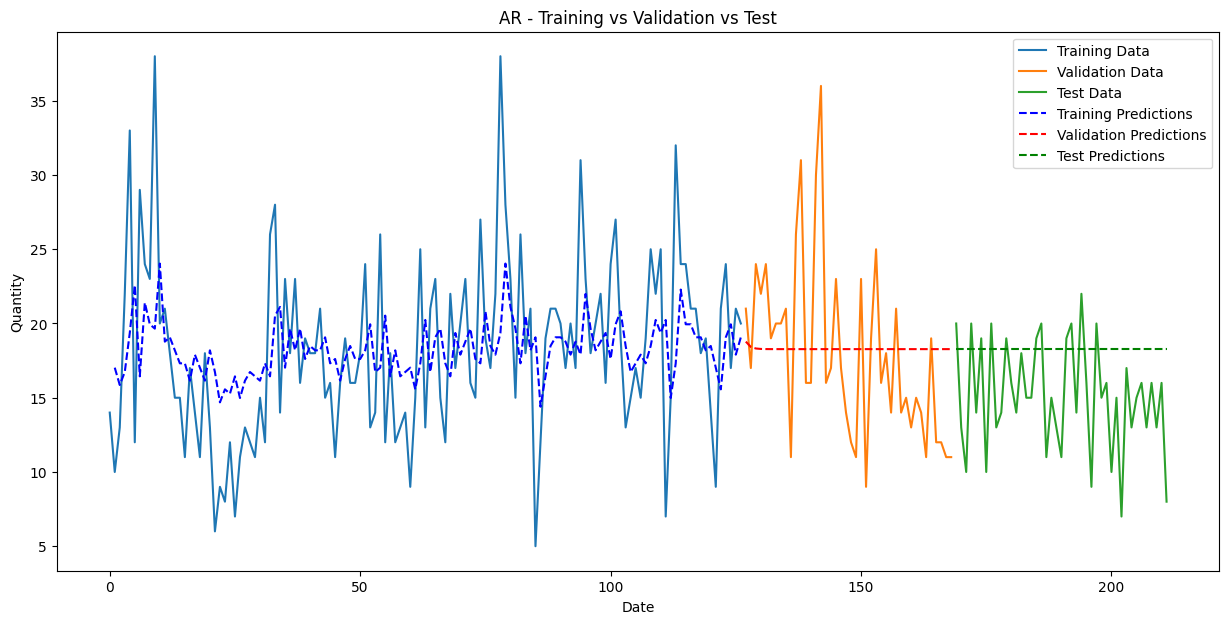

Validation Set Metrics for AR:
MSE: 35.390861987384206 
MAE: 4.79104632790376 
MAPE: 29.412%

Test Set Metrics for AR:
MSE: 23.27032762215448 
MAE: 3.970837259954068 
MAPE: 33.668%


In [645]:
plot_predictions_and_metrics(train_df, val_df, test_df, AR_result, model_name='AR')

### MA Model

In [646]:
# Define and fit MA model
MA_model = ARIMA(train_df['Quantity'], order=(0, 0, 1))     # MA(1) model
MA_result = MA_model.fit()

# Print model summary
# print(MA_result.summary())

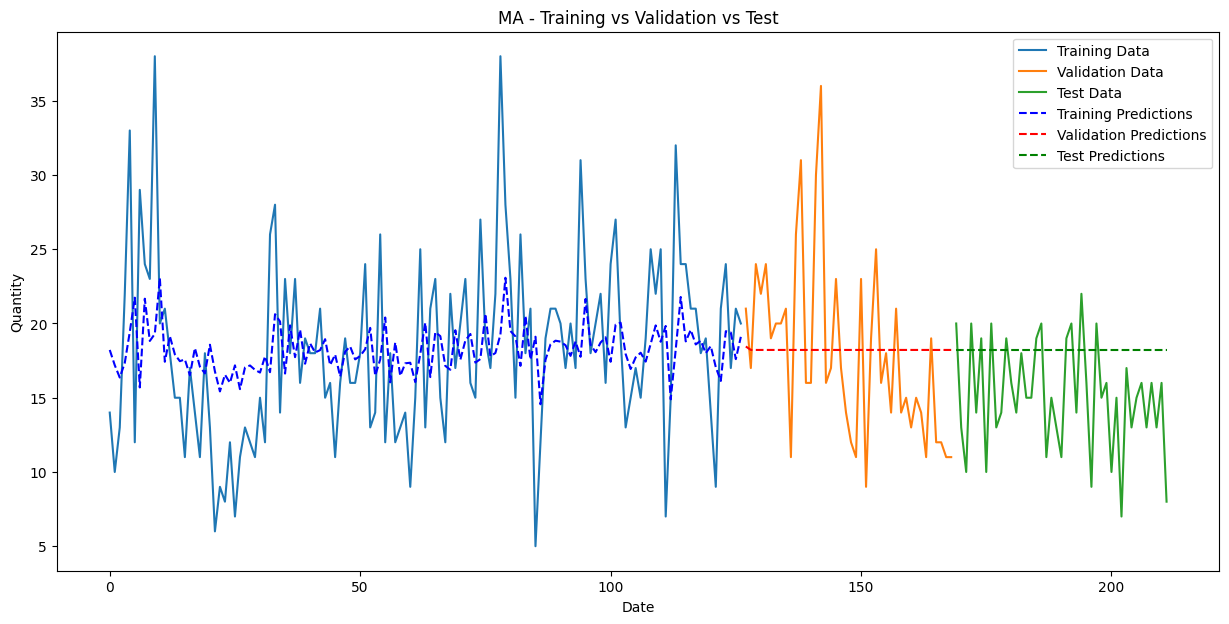

Validation Set Metrics for MA:
MSE: 35.39928979101906 
MAE: 4.787626155146834 
MAPE: 29.297%

Test Set Metrics for MA:
MSE: 22.92531257030517 
MAE: 3.9441194044408863 
MAPE: 33.421%


In [647]:
plot_predictions_and_metrics(train_df, val_df, test_df, MA_result, model_name='MA')

### ARMA Model

In [648]:
# fitting the model
ARMA_model = ARIMA(train_df['Quantity'], order=(1, 0, 1))           # ARMA(1, 1) Model   
ARMA_result = ARMA_model.fit()          

# Print model summary
# print(ARMA_result.summary())                       

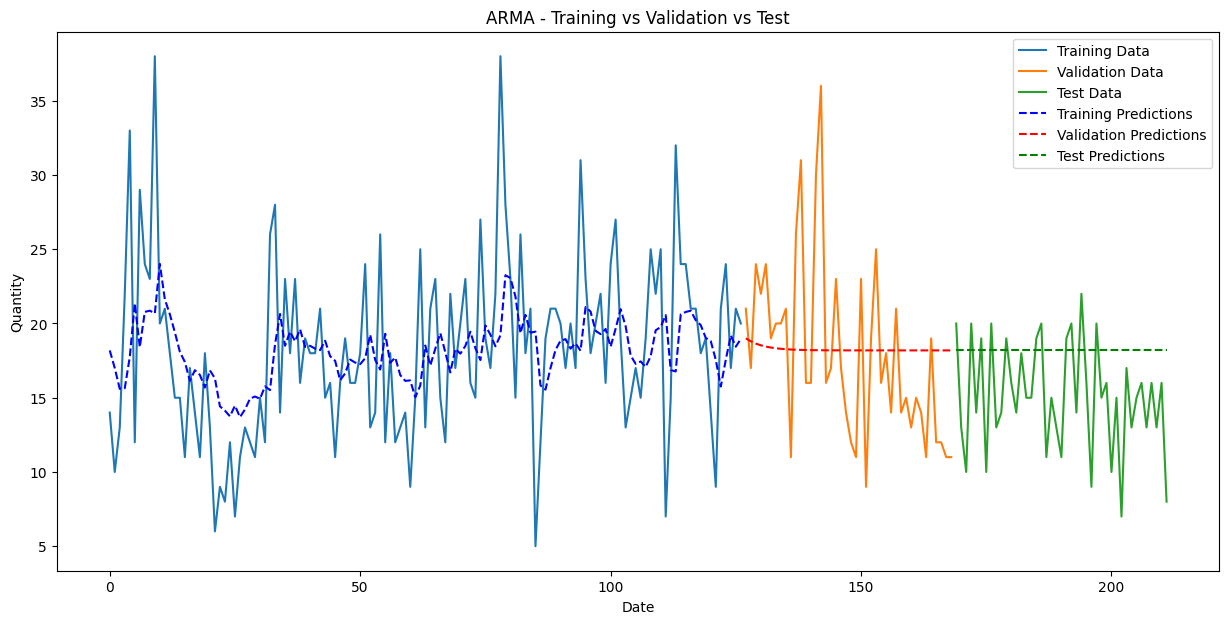

Validation Set Metrics for ARMA:
MSE: 35.05135718042404 
MAE: 4.746750557674151 
MAPE: 29.086%

Test Set Metrics for ARMA:
MSE: 22.73237289436732 
MAE: 3.9289722056512426 
MAPE: 33.281%


In [649]:
plot_predictions_and_metrics(train_df, val_df, test_df, ARMA_result, model_name='ARMA')

### ARIMA Model

In [650]:
# fitting the model
ARIMA_model = ARIMA(train_df['Quantity'], order=(1, 0, 1))           # ARIMA(1, 0, 1) Model   
ARIMA_result = ARIMA_model.fit()          

# Print model summary
# print(ARIMA_result.summary())                       

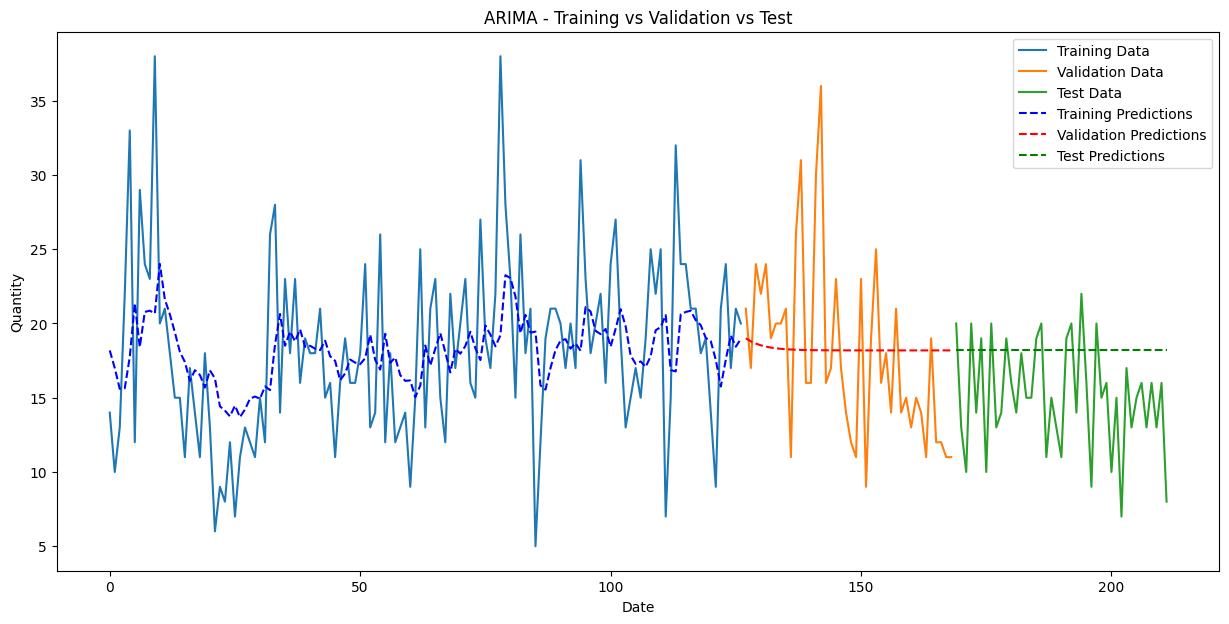

Validation Set Metrics for ARIMA:
MSE: 35.05135718042404 
MAE: 4.746750557674151 
MAPE: 29.086%

Test Set Metrics for ARIMA:
MSE: 22.73237289436732 
MAE: 3.9289722056512426 
MAPE: 33.281%


In [651]:
plot_predictions_and_metrics(train_df, val_df, test_df, ARIMA_result, model_name='ARIMA')

### SARIMA Model

* <i>`Seasonality` taken as 6 because
    * potential pattern every 6 month
    * gives least error as compared to 7 or 12 month

In [652]:
# Define and fit SARIMA model
sarima_model = SARIMAX(train_df['Quantity'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 6))         # potential seasonal pattern every 6 months and 6 gives the least error
sarima_model = sarima_model.fit()

# Print model summary
# print(result_sarima.summary())

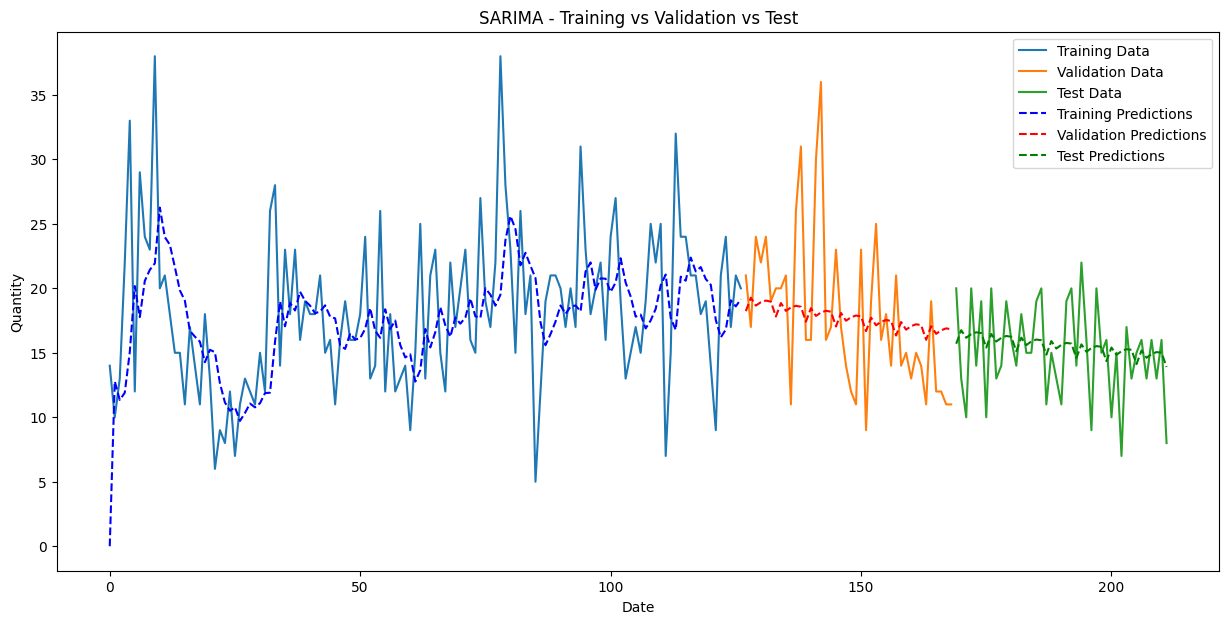

Validation Set Metrics for SARIMA:
MSE: 31.822343609006193 
MAE: 4.448567268146645 
MAPE: 26.227%

Test Set Metrics for SARIMA:
MSE: 11.946178533386432 
MAE: 2.842762243190187 
MAPE: 22.315%


In [653]:
plot_predictions_and_metrics(train_df, val_df, test_df, sarima_model, model_name='SARIMA')

### ARIMAX Model

In [654]:
# Drop NaN values for modeling
train_df = train_df.dropna(subset=['Clicks_stationary'])
val_df = val_df.dropna(subset=['Clicks_stationary'])
test_df = test_df.dropna(subset=['Clicks_stationary'])

* Using `Impressions` and `Clicks_stationary` together as `exogenous variable` gives the <u>least error</u>.
* Meanwhile, Taking them separately gives <u>high error<u>.

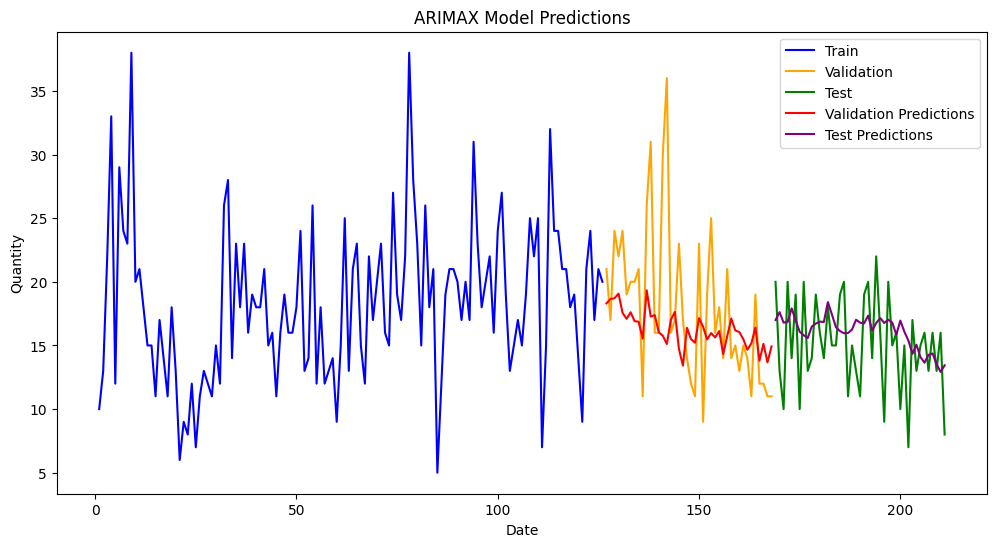

ARIMAX Validation Set Metrics:
MSE: 34.12351836103625
MAE: 4.1931957104006985
MAPE: 22.296%

ARIMAX Test Set Metrics:
MSE: 13.83956543464899
MAE: 3.1295384092829055
MAPE: 25.027%


In [655]:
# Define exogenous variables for train, validation, and test sets
exog_train = train_df[['Clicks_stationary', 'Impressions']]
exog_val = val_df[['Clicks_stationary', 'Impressions']]
exog_test = test_df[['Clicks_stationary', 'Impressions']]

# Fit the ARIMAX model
arimax_model = SARIMAX(train_df['Quantity'], exog=exog_train, order=(1, 0, 1)).fit()

# Call the function to plot predictions and calculate metrics
plot_predictions_and_metrics_exog(train_df, val_df, test_df, exog_val, exog_test, arimax_model, 'ARIMAX')

### SARIMAX Model

* Using `Impressions` and `Clicks_stationary` together as `exogenous variable` gives the <u>least error</u>.
* Meanwhile, Taking them separately gives <u>high error</u>.
* `Seasonality` is taken 12 for lowest error.

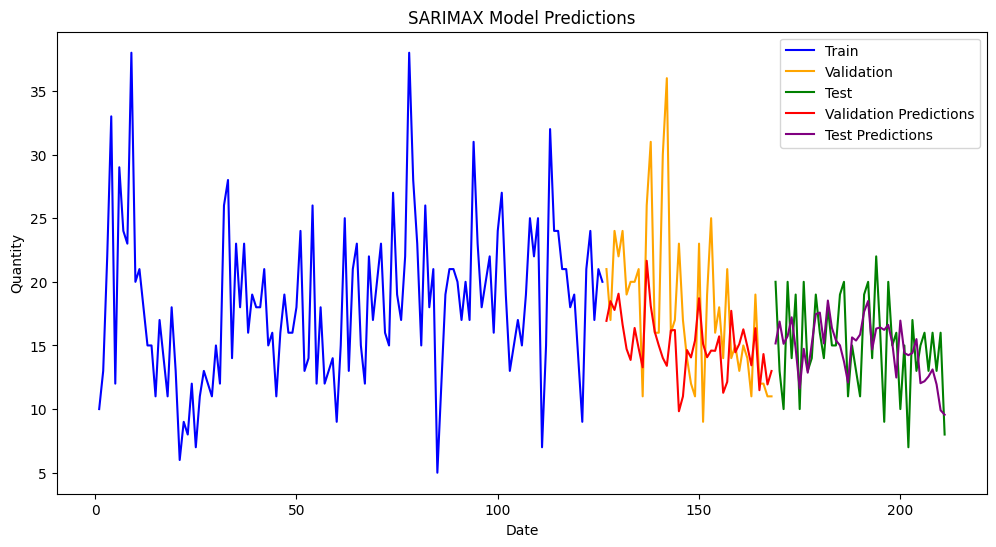

SARIMAX Validation Set Metrics:
MSE: 41.55460416519864
MAE: 4.503744563992768
MAPE: 22.522%

SARIMAX Test Set Metrics:
MSE: 12.491696279219278
MAE: 2.8409982352938226
MAPE: 21.022%


In [656]:
exog_train = train_df[['Clicks_stationary', 'Impressions']]
exog_val = val_df[['Clicks_stationary', 'Impressions']]
exog_test = test_df[['Clicks_stationary', 'Impressions']]

# Fit the SARIMAX model
sarimax_model = SARIMAX(train_df['Quantity'], exog=exog_train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12)).fit()              #  12 month seasonality gives least error

# Call the function to plot predictions and calculate metrics
plot_predictions_and_metrics_exog(train_df, val_df, test_df, exog_val, exog_test, sarimax_model, 'SARIMAX')

### ARIMAX / SARIMAX - with AdStock

#### <i> finding best decay factor

In [657]:
def adstock_transform(series, decay_factor):
    transformed_values = [0]  # Start with 0 adstock for the first observation
    for i in range(1, len(series)):
        transformed_values.append(series[i] + decay_factor * transformed_values[i - 1])
    transformed_series = pd.Series(transformed_values, index=series.index)
    return transformed_series
def find_best_decay_factor(df, decay_factors):
    best_decay_factor = None
    best_total_mape = np.inf

    for decay_factor in decay_factors:
        df['Clicks_adstock'] = adstock_transform(df['Clicks'], decay_factor)

        # Calculate the split indices
        train_size = int(0.6 * len(df))
        val_size = int(0.2 * len(df))
        test_size = len(df) - train_size - val_size

        # Split the df
        train_df = df.iloc[:train_size]
        val_df = df.iloc[train_size:train_size + val_size]
        test_df = df.iloc[train_size + val_size:]

        # Train SARIMAX model
        model = SARIMAX(train_df['Quantity'], exog=train_df[['Clicks_adstock', 'Impressions']], order=(1, 0, 1))
        sarimax_model = model.fit(disp=False)

        # Forecasting on validation and test sets
        forecast_val = sarimax_model.get_forecast(steps=len(val_df), exog=val_df[['Clicks_adstock', 'Impressions']]).predicted_mean
        forecast_test = sarimax_model.get_forecast(steps=len(test_df), exog=test_df[['Clicks_adstock', 'Impressions']]).predicted_mean

        def calculate_mape(actual_values, predicted_values):
            actual_values = np.array(actual_values)
            predicted_values = np.array(predicted_values)
            abs_percentage_error = np.abs((actual_values - predicted_values) / actual_values)
            abs_percentage_error[np.isnan(abs_percentage_error)] = 0
            mape = np.mean(abs_percentage_error) * 100
            return mape 
    
        # Calculate MAPE
        mape_val = calculate_mape(val_df['Quantity'], forecast_val)
        mape_test = calculate_mape(test_df['Quantity'], forecast_test)
        total_mape = mape_val + mape_test

        # Check if current decay factor is better
        if total_mape < best_total_mape:
            best_total_mape = total_mape
            best_decay_factor = decay_factor

        # Print MAPE values
        print(f'Decay Factor: {decay_factor:.3f}, Validation MAPE: {mape_val:.3f}, Test MAPE: {mape_test:.3f}, Total MAPE: {total_mape:.3f}')

    return best_decay_factor

# Initial grid search for decay factor
decay_factors = np.linspace(0.9, 1.0, 10)
best_decay_factor = find_best_decay_factor(df, decay_factors)

# Refine search to three decimal places
for i in range(2, 4):  # Increasing the range for finer granularity
    lower_bound = best_decay_factor - 10**-i
    upper_bound = best_decay_factor + 10**-i
    decay_factors = np.linspace(lower_bound, upper_bound, 10)
    best_decay_factor = find_best_decay_factor(df, decay_factors)

# Use the best decay factor found
print(f'Best Decay Factor: {best_decay_factor:.3f}')


Decay Factor: 0.900, Validation MAPE: 22.743, Test MAPE: 45.614, Total MAPE: 68.358
Decay Factor: 0.911, Validation MAPE: 22.035, Test MAPE: 44.959, Total MAPE: 66.993
Decay Factor: 0.922, Validation MAPE: 21.161, Test MAPE: 43.163, Total MAPE: 64.324
Decay Factor: 0.933, Validation MAPE: 20.961, Test MAPE: 41.061, Total MAPE: 62.022
Decay Factor: 0.944, Validation MAPE: 21.893, Test MAPE: 38.029, Total MAPE: 59.921
Decay Factor: 0.956, Validation MAPE: 23.735, Test MAPE: 33.728, Total MAPE: 57.463
Decay Factor: 0.967, Validation MAPE: 27.226, Test MAPE: 28.123, Total MAPE: 55.349
Decay Factor: 0.978, Validation MAPE: 32.602, Test MAPE: 22.670, Total MAPE: 55.273
Decay Factor: 0.989, Validation MAPE: 41.675, Test MAPE: 30.622, Total MAPE: 72.297
Decay Factor: 1.000, Validation MAPE: 65.833, Test MAPE: 99.869, Total MAPE: 165.702
Decay Factor: 0.968, Validation MAPE: 24.964, Test MAPE: 30.408, Total MAPE: 55.371
Decay Factor: 0.970, Validation MAPE: 28.618, Test MAPE: 26.354, Total MAPE

<i>best decay factor found is 0.973

#### <i>Modelling

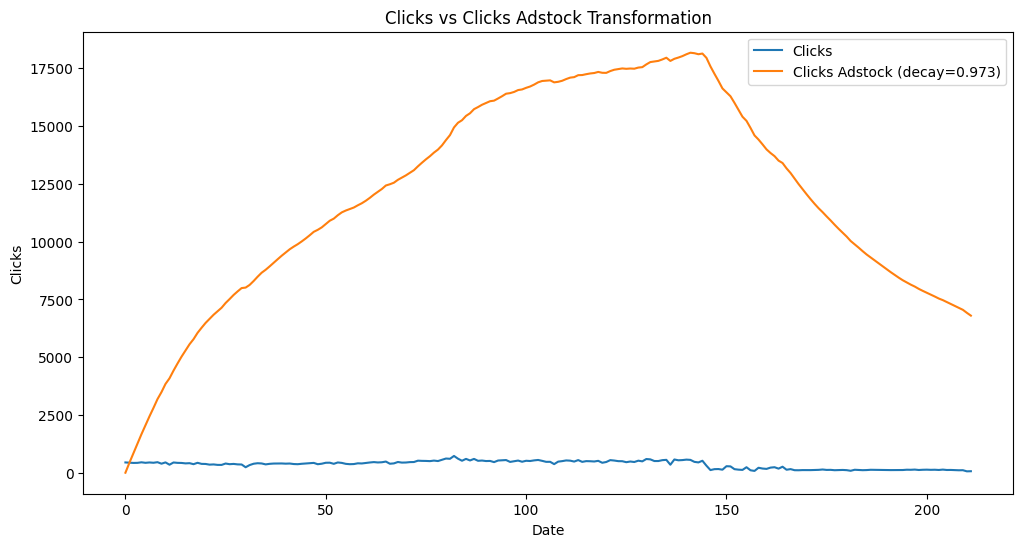

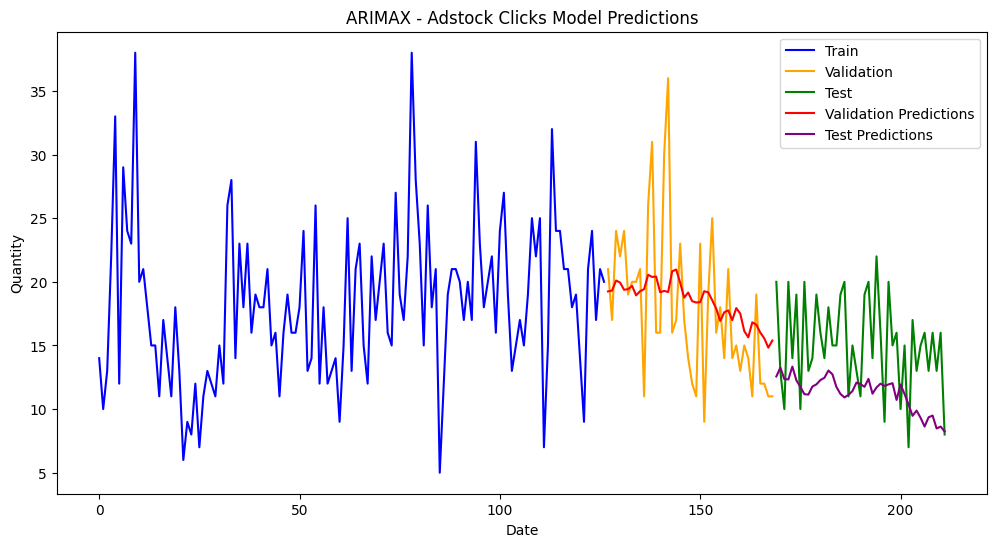

ARIMAX - Adstock Clicks Validation Set Metrics:
MSE: 28.765405522025606
MAE: 4.258532459141807
MAPE: 26.15%

ARIMAX - Adstock Clicks Test Set Metrics:
MSE: 27.511882066803057
MAE: 4.447944040355851
MAPE: 27.586%


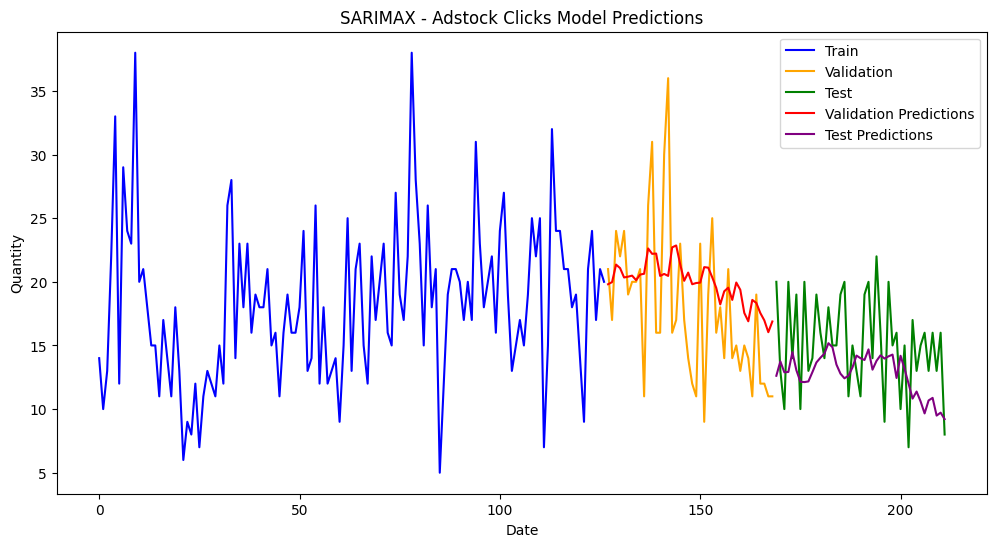

SARIMAX - Adstock Clicks Validation Set Metrics:
MSE: 32.86117278654616
MAE: 4.653257930336601
MAPE: 30.703%

SARIMAX - Adstock Clicks Test Set Metrics:
MSE: 18.646537839506554
MAE: 3.5904783511865817
MAPE: 23.586%


In [658]:
decay_factor = 0.973

df['Clicks_adstock'] = adstock_transform(df['Clicks'], decay_factor)

# Plotting both original and adstock-transformed series
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Clicks'], label='Clicks')
plt.plot(df.index, df['Clicks_adstock'], label=f'Clicks Adstock (decay={decay_factor})')
plt.xlabel('Date')
plt.ylabel('Clicks')
plt.legend()
plt.title('Clicks vs Clicks Adstock Transformation')
plt.show()

# Calculate the split indices
train_size = int(0.6 * len(df))
val_size = int(0.2 * len(df))
test_size = len(df) - train_size - val_size

# Split the df
train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:train_size + val_size]
test_df = df.iloc[train_size + val_size:]

# model
exog_train = train_df[['Clicks_adstock', 'Impressions']]
exog_val = val_df[['Clicks_adstock', 'Impressions']]
exog_test = test_df[['Clicks_adstock', 'Impressions']]

# Fit the ARIMAX model
arimax_model = SARIMAX(train_df['Quantity'], exog=exog_train, order=(1, 0, 1)).fit()              

# Call the function to plot predictions and calculate metrics
plot_predictions_and_metrics_exog(train_df, val_df, test_df, exog_val, exog_test, arimax_model, 'ARIMAX - Adstock Clicks')

# Fit the SARIMAX model 
sarimax_model = SARIMAX(train_df['Quantity'], exog=exog_train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12)).fit()              #  12 month seasonality gives least error

# Call the function to plot predictions and calculate metrics
plot_predictions_and_metrics_exog(train_df, val_df, test_df, exog_val, exog_test, sarimax_model, 'SARIMAX - Adstock Clicks')

* <i>Models (ARIMAX & SARIMAX) where `Clicks_stationary` was used, performed better than those which used `Clicks_adstock`.
    * `Clicks_stationary` used differencing 
    * `Clicks_adstock` used adstock-transform

### COMPARISON OF MODELS

<style>
  .red-text { color: red; }
  .yellow-text { color: yellow; }
  .green-text { color: green; }
</style>
<span class="red-text"><b>Total MAPE > 50</b></span><br>
<span class="yellow-text"><b>50 > Total MAPE > 45</b></span><br>
<span class="green-text"><b>Total MAPE < 45</b></span>



<table style="width:100%; border-collapse: collapse; border: 1px solid #ddd; font-size: 14px;">
  <thead>
    <tr>
      <th style="padding: 10px; text-align: left; font-size: 16px;">Set</th>
      <th style="padding: 10px; text-align: left; font-size: 16px;">Metric / Model</th>
      <th style="padding: 10px; text-align: center; font-size: 16px;">AR</th>
      <th style="padding: 10px; text-align: center; font-size: 16px;">MA</th>
      <th style="padding: 0px; text-align: center; font-size: 16px;">ARMA / ARIMA</th>
      <th style="padding: 0px; text-align: center; font-size: 16px;">ARIMAX - Clicks_stationary</th>
      <th style="padding: 10px; text-align: center; font-size: 16px;">SARIMA</th>
      <th style="padding: 0px; text-align: center; font-size: 16px;">SARIMAX - Clicks_stationary</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td rowspan="3" style="padding: 10px;"><b style="font-size: 18px;">Validation</b></td>
      <td style="padding: 10px;">MSE</td>
      <td style="padding: 10px; text-align: center;">35.3909</td>
      <td style="padding: 10px; text-align: center;">35.3993</td>
      <td style="padding: 10px; text-align: center;">35.0514</td>
      <td style="padding: 10px; text-align: center;">34.1235</td>
      <td style="padding: 10px; text-align: center;">31.8223</td>
      <td style="padding: 10px; text-align: center;">41.5546</td>
    </tr>
    <tr>
      <td style="padding: 10px;">MAE</td>
      <td style="padding: 10px; text-align: center;">4.7910</td>
      <td style="padding: 10px; text-align: center;">4.7876</td>
      <td style="padding: 10px; text-align: center;">4.7468</td>
      <td style="padding: 10px; text-align: center;">4.1932</td>
      <td style="padding: 10px; text-align: center;">4.4486</td>
      <td style="padding: 10px; text-align: center;">4.5037</td>
    </tr>
    <tr>
      <td style="padding: 10px;">MAPE</td>
      <td style="padding: 10px; text-align: center;color:red;">29.412%</td>
      <td style="padding: 10px; text-align: center;color:red;">29.297%</td>
      <td style="padding: 10px; text-align: center;color:red;">29.086%</td>
      <td style="padding: 10px; text-align: center;color: yellow;">25.024%</td>
      <td style="padding: 10px; text-align: center;color: yellow;">26.227%</td>
      <td style="padding: 10px; text-align: center; color: green;"><i><b>22.522%</i></td>
    </tr>
    <tr>
      <td rowspan="3" style="padding: 10px;"><b style="font-size: 18px;">Test set</b></td>
      <td style="padding: 10px;">MSE</td>
      <td style="padding: 10px; text-align: center;">23.2703</td>
      <td style="padding: 10px; text-align: center;">22.9253</td>
      <td style="padding: 10px; text-align: center;">22.7324</td>
      <td style="padding: 10px; text-align: center;">13.8396</td>
      <td style="padding: 10px; text-align: center;">11.9462</td>
      <td style="padding: 10px; text-align: center;">12.4917</td>
    </tr>
    <tr>
      <td style="padding: 10px;">MAE</td>
      <td style="padding: 10px; text-align: center;">3.9708</td>
      <td style="padding: 10px; text-align: center;">3.9441</td>
      <td style="padding: 10px; text-align: center;">3.9290</td>
      <td style="padding: 10px; text-align: center;">3.1295</td>
      <td style="padding: 10px; text-align: center;">2.8428</td>
      <td style="padding: 10px; text-align: center;">2.8410</td>
    </tr>
    <tr>
      <td style="padding: 10px;">MAPE</td>
      <td style="padding: 10px; text-align: center;color: red;">33.668%</td>
      <td style="padding: 10px; text-align: center;color: red;">33.421%</td>
      <td style="padding: 10px; text-align: center;color: red;">33.281%</td>
      <td style="padding: 10px; text-align: center;color: yellow;">25.027%</td>
      <td style="padding: 10px; text-align: center;color: yellow;">22.315%</td>
      <td style="padding: 10px; text-align: center; color: green;"><i><b>21.022%</i></td>
    </tr>
  </tbody>
</table>


<table style="width:100%; border-collapse: collapse; border: 1px solid #ddd; font-size: 14px;">
  <thead>
    <tr>
      <th style="padding: 10px; text-align: left; font-size: 16px;">Set</th>
      <th style="padding: 10px; text-align: left; font-size: 16px;">Metric / Model</th>
      <th style="padding: 10px; text-align: center; font-size: 16px;">ARIMAX - Adstock Clicks</th>
      <th style="padding: 10px; text-align: center; font-size: 16px;">SARIMAX - Adstock Clicks</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td rowspan="3" style="padding: 10px; vertical-align: middle; font-weight: bold;">Validation</td>
      <td style="padding: 10px;">MSE</td>
      <td style="padding: 10px; text-align: center;">28.7654</td>
      <td style="padding: 10px; text-align: center;">32.8612</td>
    </tr>
    <tr>
      <td style="padding: 10px;">MAE</td>
      <td style="padding: 10px; text-align: center;">4.2585</td>
      <td style="padding: 10px; text-align: center;">4.6533</td>
    </tr>
    <tr>
      <td style="padding: 10px;">MAPE</td>
      <td style="padding: 10px; text-align: center;color: red;">26.15%</td>
      <td style="padding: 10px; text-align: center;color: red;">30.703%</td>
    </tr>
    <tr>
      <td rowspan="3" style="padding: 10px; vertical-align: middle; font-weight: bold;">Test</td>
      <td style="padding: 10px;">MSE</td>
      <td style="padding: 10px; text-align: center;">27.5119</td>
      <td style="padding: 10px; text-align: center;">18.6465</td>
    </tr>
    <tr>
      <td style="padding: 10px;">MAE</td>
      <td style="padding: 10px; text-align: center;">4.4479</td>
      <td style="padding: 10px; text-align: center;">3.5905</td>
    </tr>
    <tr>
      <td style="padding: 10px;">MAPE</td>
      <td style="padding: 10px; text-align: center;color: red;">27.586%</td>
      <td style="padding: 10px; text-align: center;color: red;">23.586%</td>
    </tr>
  </tbody>
</table>
